# Durban Port Congestion Simulation
### **Discrete event simulation of Crane Scheduling & Yard Dwell Time**

This notebook models the flow of containers through the Durban Container Terminal using a Discrete Event Simulation (DES) approach.
The goal is to:

- Identify bottlenecks
- Model realistic delays
- Test optimisation strategies such as:
    1. Crane Scheduling Optimisation
    2. Yard Dwell Time Reduction

This notebook is structured to reflect the real-world operations of Durban Port, including:

- Offloading by STS cranes
- Yard capacity constraints
- Scanning delays (SARS)
- Truck loading
- Gate-out processing

We will build the simulation step-by-step, with explanations for each block.

In [1]:
import simpy
import random
import numpy as np
import pandas as pd
from truck_tas import TruckTASParams, truck_tas_arrival_generator


Listed above, are the core libraries for our simulation:
- simpy : Discrete event simulation engine
- random : Stochastic arrival patterns
- numpy : numerical operations
- pandas : storing and analysing the results

This is the minimal set we need to start building our model.

In [2]:
# -----------------------------
# Global Parameters (Week 1 Data + Realistic Behaviour Enhancements)
# -----------------------------

# Cranes (STS)
NUM_CRANES = 16
CRANE_MOVES_PER_HOUR = 18
CRANE_TIME = 60 / CRANE_MOVES_PER_HOUR

# Yard (capacity in TEU slots)
YARD_CAPACITY = 10000

# Yard handling equipment (pooled)
# SOURCE-ANCHORED vs ASSUMPTION notes:
# - Capacity and availability are SOURCE-ANCHORED (NotebookLM extraction).
# - Move-time max and rehandle penalty are ASSUMPTION TO TUNE.
YARD_EQUIP_CAPACITY_NOMINAL = 109  # SOURCE-ANCHORED
YARD_EQUIP_CAPACITY_CRISIS_RANGE = (49, 55)  # SOURCE-ANCHORED range (optional stress scenario)
YARD_EQUIP_AVAIL_TARGET = 0.59  # SOURCE-ANCHORED
YARD_EQUIP_CAPACITY_EFFECTIVE = max(1, round(YARD_EQUIP_CAPACITY_NOMINAL * YARD_EQUIP_AVAIL_TARGET))

YARD_MOVE_MIN = 6.0    # SOURCE-ANCHORED
YARD_MOVE_MODE = 6.67  # SOURCE-ANCHORED
YARD_MOVE_MAX = 15.0   # ASSUMPTION TO TUNE

YARD_OCC_THRESHOLD = 0.80  # SOURCE-ANCHORED
REHANDLE_ALPHA = 1.25      # ASSUMPTION TO TUNE


def sample_yard_move_time(yard):
    """
    Returns a yard move time in minutes.

    Base: triangular(YARD_MOVE_MIN, YARD_MOVE_MODE, YARD_MOVE_MAX).
    If yard occupancy > YARD_OCC_THRESHOLD, apply a congestion penalty:
        penalty = 1 + REHANDLE_ALPHA * (occ - threshold) / (1 - threshold)
    This represents rehandles/stacking friction under high occupancy.
    """
    base = random.triangular(YARD_MOVE_MIN, YARD_MOVE_MODE, YARD_MOVE_MAX)
    if YARD_CAPACITY <= 0:
        return max(0.0, base)

    occ = yard.level / YARD_CAPACITY
    occ = max(0.0, min(1.0, occ))
    if occ <= YARD_OCC_THRESHOLD:
        return max(0.0, base)

    denom = max(1e-6, (1.0 - YARD_OCC_THRESHOLD))
    penalty = 1.0 + REHANDLE_ALPHA * (occ - YARD_OCC_THRESHOLD) / denom
    return max(0.0, base * penalty)

# Scanners (SARS)
NUM_SCANNERS = 2
SCAN_TIME = 10  # fixed scanning time (minutes)

# Container mix (assumption until data is available)
PCT_40FT = 0.30  # 40ft = 2 TEU, 20ft = 1 TEU

def sample_teu_size():
    return 2 if random.random() < PCT_40FT else 1

# Truck capacity and arrivals
TRUCK_CAPACITY_TEU = 2
TRUCK_TEU_BASE_RATE = 18  # TEU per hour (synthetic profile fallback)

# Arrival data inputs (processed datasets)
TRUCK_ARRIVAL_DATA_PATH = "data/processed/unit_volume/unit_volume_long.csv"
TRUCK_ARRIVAL_DATA_FALLBACK_PATH = "data/processed/unit_volume/unit_volume_wide.csv"
TRUCK_ARRIVAL_FACILITY = "DCT"
TRUCK_ARRIVAL_CATEGORY = "IMPORT"
TRUCK_ARRIVAL_REPORT_MONTH = None  # use latest available month when None

# --------------------------------------------------------
# Integrated Dwell (MVIA-style) parameters
# --------------------------------------------------------
# 72-hour free time window (Pier 2 reference) expressed in minutes.
FREE_TIME_72H = 72 * 60

# Baseline behavior: higher deadline clustering and higher holds/rebooking.
DEADLINE_GROUP_PROB_BASE = 0.50
DEADLINE_WINDOW_MINS_BASE = 12 * 60
EARLY_PICKUP_MAX_MINS_BASE = 60 * 60
CUSTOMS_HOLD_PROB_BASE = 0.08
CUSTOMS_HOLD_MIN_MINS = 2 * 24 * 60
CUSTOMS_HOLD_MAX_MINS = 5 * 24 * 60
REBOOK_DELAY_MINS_BASE = 24 * 60

# Congestion proxy thresholds (queue lengths).
# These are tuned to resource scale to avoid overly aggressive rebooking.
QUEUE_THRESHOLD_SCANNER = 10
QUEUE_THRESHOLD_LOADER = 20

# Improved behavior: earlier pickup requests and lower hold/rebook rates.
DEADLINE_GROUP_PROB_IMP = 0.30
DEADLINE_WINDOW_MINS_IMP = 12 * 60
EARLY_PICKUP_MAX_MINS_IMP = 48 * 60
CUSTOMS_HOLD_PROB_IMP = 0.05
REBOOK_DELAY_MINS_IMP = 12 * 60

DWELL_PARAMS_BASE = {
    "free_time_mins": FREE_TIME_72H,
    "deadline_group_prob": DEADLINE_GROUP_PROB_BASE,
    "deadline_window_mins": DEADLINE_WINDOW_MINS_BASE,
    "early_pickup_max_mins": EARLY_PICKUP_MAX_MINS_BASE,
    "customs_hold_prob": CUSTOMS_HOLD_PROB_BASE,
    "customs_hold_min_mins": CUSTOMS_HOLD_MIN_MINS,
    "customs_hold_max_mins": CUSTOMS_HOLD_MAX_MINS,
    "rebook_delay_mins": REBOOK_DELAY_MINS_BASE,
}

DWELL_PARAMS_IMP = {
    "free_time_mins": FREE_TIME_72H,
    "deadline_group_prob": DEADLINE_GROUP_PROB_IMP,
    "deadline_window_mins": DEADLINE_WINDOW_MINS_IMP,
    "early_pickup_max_mins": EARLY_PICKUP_MAX_MINS_IMP,
    "customs_hold_prob": CUSTOMS_HOLD_PROB_IMP,
    "customs_hold_min_mins": CUSTOMS_HOLD_MIN_MINS,
    "customs_hold_max_mins": CUSTOMS_HOLD_MAX_MINS,
    "rebook_delay_mins": REBOOK_DELAY_MINS_IMP,
}

# --------------------------------------------------------
# Customs inspection (queue + service)
# --------------------------------------------------------
# Inspection service is short; the long delay is modeled as the hold itself.
NUM_CUSTOMS_INSPECTION_BAYS = 2
CUSTOMS_INSPECTION_TIME_MIN = 30
CUSTOMS_INSPECTION_TIME_MODE = 60
CUSTOMS_INSPECTION_TIME_MAX = 120

def sample_customs_inspection_time():
    return random.triangular(
        CUSTOMS_INSPECTION_TIME_MIN,
        CUSTOMS_INSPECTION_TIME_MODE,
        CUSTOMS_INSPECTION_TIME_MAX,
    )

# --------------------------------------------------------
# Truck Loading (per truck; service-time assumption)
# --------------------------------------------------------
# Baseline uses a more realistic number of bays (Pier 2 reference: 20 bays).
NUM_LOADING_BAYS = 20

LOADING_TIME_MIN = 15
LOADING_TIME_MODE = 25
LOADING_TIME_MAX = 45

def sample_loading_time():
    # triangular distribution: min=15, mode=25, max=45 minutes
    return random.triangular(LOADING_TIME_MIN, LOADING_TIME_MODE, LOADING_TIME_MAX)


def estimate_required_loading_bays(hourly_teu_rate, min_bays):
    '''
    Estimate loading bays needed to match average arrival volume.
    This ties capacity to observed unit volume rates and directly affects
    loading_wait and truck turnaround KPIs.
    '''
    avg_loading_time = (LOADING_TIME_MIN + LOADING_TIME_MODE + LOADING_TIME_MAX) / 3
    trucks_per_hour = float(np.mean(hourly_teu_rate)) / TRUCK_CAPACITY_TEU
    service_rate_per_bay = 60.0 / avg_loading_time
    required = int(np.ceil(trucks_per_hour / service_rate_per_bay))
    return max(min_bays, required)

# --------------------------------------------------------
# Gate-In and Gate-Out (separate resources)
# --------------------------------------------------------
NUM_GATE_IN_LANES = 1
NUM_GATE_OUT_LANES = 1

def sample_gate_in_time():
    # triangular distribution: min=0.2, mode=0.5, max=2.0 minutes
    return random.triangular(0.2, 0.5, 2.0)

def sample_gate_out_time():
    # triangular distribution: min=0.5, mode=1.0, max=3.0 minutes
    return random.triangular(0.5, 1.0, 3.0)

# --------------------------------------------------------
# Truck Arrival + TAS (Phase 2) parameters
# --------------------------------------------------------
# SOURCE-ANCHORED vs ASSUMPTION notes:
# - The counts below are provisional placeholders to be tuned.
# - Slot rules (length, late tolerance, no-show, rebook) are ASSUMPTION TO TUNE.

TRUCKS_PER_DAY_PIER2_BASE = 3000  # ASSUMPTION TO TUNE (provisional)
TRUCKS_PER_DAY_PIER1_BASE = 1000  # ASSUMPTION TO TUNE (provisional)
GATE_LANES_PIER2 = 7  # ASSUMPTION TO TUNE (pedestals vs lanes)

TAS_SLOT_MINUTES = 60  # ASSUMPTION TO TUNE
TAS_LATE_TOLERANCE_MINS = 30  # ASSUMPTION TO TUNE
NO_SHOW_PROB = 0.22  # ASSUMPTION TO TUNE

# Rebook delay modeled as lognormal(mean, sigma) in minutes (ASSUMPTION TO TUNE).
REBOOK_DELAY_MEAN_MINS = 360
REBOOK_DELAY_SIGMA_MINS = 120

# Arrival deviation around booked slot start (ASSUMPTION TO TUNE).
ARRIVAL_STD_MINS = 15

# Typical hourly profile (normalized to sum to 24).
HOURLY_ARRIVAL_MULTIPLIERS = [
    0.444, 0.38, 0.355, 0.38, 0.507, 0.761,
    1.014, 1.268, 1.458, 1.521, 1.458, 1.395,
    1.331, 1.268, 1.268, 1.331, 1.395, 1.458,
    1.268, 1.078, 0.887, 0.697, 0.571, 0.507,
]

# --------------------------------------------------------
# Truck Arrival Profile Adapter
# --------------------------------------------------------

def _hourly_shape_weights():
    return [
        0.35, 0.30, 0.28, 0.30, 0.40, 0.60,
        0.80, 1.00, 1.15, 1.20, 1.15, 1.10,
        1.05, 1.00, 1.00, 1.05, 1.10, 1.15,
        1.00, 0.85, 0.70, 0.55, 0.45, 0.40
    ]


def _scale_hourly_from_daily(daily_teu):
    weights = np.array(_hourly_shape_weights(), dtype=float)
    weights = weights / weights.mean()
    hourly_teu_rate = (daily_teu / 24.0) * weights
    return hourly_teu_rate.tolist()


def _is_month_col(col):
    return (
        isinstance(col, str)
        and len(col) == 7
        and col[4] == "-"
        and col[:4].isdigit()
        and col[5:7].isdigit()
    )


def load_teu_arrival_profile(
    path=None,
    facility_code="DCT",
    category_filter="IMPORT",
    report_month=None,
    base_teu_per_hour=TRUCK_TEU_BASE_RATE,
):
    '''
    Returns:
        hourly_teu_rate (list[float]), rate_fn (callable): rate_fn(t_min) -> TEU/hour

    Data sources supported:
    - data/processed/unit_volume/unit_volume_long.csv (TEU inferred from type_length)
    - data/processed/unit_volume/unit_volume_wide.csv (monthly totals; TEU estimated from mix)
    - hourly TEU table with columns: date, hour, facility_code, teu_total (or teus)
    '''
    if path is None:
        hourly_teu_rate = [base_teu_per_hour * w for w in _hourly_shape_weights()]

        def rate_fn(t_min):
            hour = int((t_min // 60) % 24)
            return hourly_teu_rate[hour]

        return hourly_teu_rate, rate_fn

    df = pd.read_csv(path)

    # Unit volume long format (processed)
    if "report_month" in df.columns and "type_length" in df.columns:
        required = {"facility_code", "report_month", "type_length", "volume"}
        missing = required - set(df.columns)
        if missing:
            raise ValueError(f"Missing columns in unit_volume_long.csv: {sorted(missing)}")

        df = df[df["facility_code"] == facility_code].copy()
        if category_filter and "category" in df.columns:
            df = df[df["category"] == category_filter].copy()

        if df.empty:
            raise ValueError("No rows found for facility/category in unit_volume_long.csv")

        length = pd.to_numeric(df["type_length"], errors="coerce")

        def length_to_teu(x):
            if pd.isna(x):
                return 1
            if x >= 40:
                return 2
            if x >= 20:
                return 1
            return 1

        teu_factor = length.apply(length_to_teu)
        volume = pd.to_numeric(df["volume"], errors="coerce").fillna(1)
        df["teu"] = volume * teu_factor

        monthly = df.groupby("report_month")["teu"].sum()
        monthly.index = monthly.index.astype(str)

        if report_month is None:
            report_month = sorted(monthly.index)[-1]
        if report_month not in monthly.index:
            raise ValueError("report_month not found in unit_volume_long.csv")

        monthly_teu = float(monthly.loc[report_month])
        days_in_month = pd.Period(report_month, freq="M").days_in_month
        daily_teu = monthly_teu / days_in_month
        hourly_teu_rate = _scale_hourly_from_daily(daily_teu)

        def rate_fn(t_min):
            hour = int((t_min // 60) % 24)
            return hourly_teu_rate[hour]

        return hourly_teu_rate, rate_fn

    # Unit volume wide format (processed)
    month_cols = [c for c in df.columns if _is_month_col(c)]
    if month_cols:
        if "unit" in df.columns:
            df = df[df["unit"].str.lower() == "containers"].copy()
        if category_filter and "category" in df.columns:
            df = df[df["category"] == category_filter].copy()

        if df.empty:
            raise ValueError("No rows found in unit_volume_wide.csv after filtering")

        long_df = df.melt(
            id_vars=[c for c in df.columns if c not in month_cols],
            value_vars=month_cols,
            var_name="report_month",
            value_name="containers",
        )
        monthly = long_df.groupby("report_month")["containers"].sum()
        monthly.index = monthly.index.astype(str)

        if report_month is None:
            report_month = sorted(monthly.index)[-1]
        if report_month not in monthly.index:
            raise ValueError("report_month not found in unit_volume_wide.csv")

        containers = float(monthly.loc[report_month])
        avg_teu_per_container = 1 + PCT_40FT  # mix-based estimate
        monthly_teu = containers * avg_teu_per_container
        days_in_month = pd.Period(report_month, freq="M").days_in_month
        daily_teu = monthly_teu / days_in_month
        hourly_teu_rate = _scale_hourly_from_daily(daily_teu)

        def rate_fn(t_min):
            hour = int((t_min // 60) % 24)
            return hourly_teu_rate[hour]

        return hourly_teu_rate, rate_fn

    # Fallback: expected hourly TEU schema
    if "facility_code" not in df.columns:
        raise ValueError("facility_code column missing in arrival profile CSV")

    df = df[df["facility_code"] == facility_code].copy()

    teus_col = None
    for col in ["teu_total", "teus", "teu"]:
        if col in df.columns:
            teus_col = col
            break
    if teus_col is None:
        raise ValueError("No TEU column found (expected: teu_total or teus)")

    if "hour" not in df.columns:
        raise ValueError("hour column missing in arrival profile CSV")

    df["hour"] = df["hour"].astype(int)
    hourly = df.groupby("hour")[teus_col].mean()

    avg = float(hourly.mean()) if not hourly.empty else 0.0
    hourly_teu_rate = [float(hourly.get(h, avg)) for h in range(24)]

    def rate_fn(t_min):
        hour = int((t_min // 60) % 24)
        return hourly_teu_rate[hour]

    return hourly_teu_rate, rate_fn

# --------------------------------------------------------
# Simulation duration
# --------------------------------------------------------
SIM_TIME = 7 * 24 * 60  # 7 days in minutes

# Dwell and post-processing buffers
# Extended to cover free-time + customs hold + rebooking tails.
MAX_DWELL = 12 * 24 * 60
POST_PROCESS_BUFFER = 6 * 60


These parameters used above come from Week 1 of the analysis:
- Crane productivity: 18 moves/hour
- Scanning: 2 scanners, 10 minutes per container
- Yard dwell: capacity-constrained (we will add dwell logic later)
- Truck loading: 20 bays at Pier 2
- Gate-out: 4 lanes
- Simulation time: 7 days (long enough to show congestion)

These variables make the model easy to modify once we begin optimisation experiments.

# Metrics Storage

In [3]:
# -----------------------------------------
# Metrics Storage
# -----------------------------------------

METRICS = []
TRUCK_METRICS = []

def reset_metrics():
    # Clear collected metrics between simulation runs.
    METRICS.clear()        # container metrics
    TRUCK_METRICS.clear()  # truck metrics

def record_metrics(container_id, timestamps):
    # Append a metrics row for one container.
    data = {"container_id": container_id}
    data.update(timestamps)
    METRICS.append(data)

def record_truck_metrics(truck_id, timestamps):
    # Append a metrics row for one truck.
    data = {"truck_id": truck_id}
    data.update(timestamps)
    TRUCK_METRICS.append(data)


# TAS metrics are stored separately to avoid mixing with baseline/improved runs.
METRICS_TAS = []
TRUCK_METRICS_TAS = []


def reset_tas_metrics():
    # Clear TAS metrics between runs to avoid mixing scenarios.
    METRICS_TAS.clear()
    TRUCK_METRICS_TAS.clear()


def record_metrics_tas(container_id, timestamps):
    # Append a metrics row for one container in TAS runs.
    data = {"container_id": container_id}
    data.update(timestamps)
    METRICS_TAS.append(data)


def record_truck_metrics_tas(truck_id, timestamps):
    # Append a metrics row for one TAS truck.
    data = {"truck_id": truck_id}
    data.update(timestamps)
    TRUCK_METRICS_TAS.append(data)


**What this does**
- Holds a global `METRICS` list for all container records.
- `reset_metrics()` clears previous runs before starting a new simulation.
- `record_metrics()` copies the timestamp dictionary into the metrics store with `container_id`.


### Container Process

# Independent Truck Arrivals + TEU Pickup (Phase Upgrade)


Data sources used for truck arrivals (processed datasets)
- data/processed/unit_volume/unit_volume_long.csv: DCT facility_code, IMPORT category; TEU inferred from type_length and volume.
- data/processed/unit_volume/unit_volume_wide.csv: fallback monthly totals if long format is unavailable (TEU estimated using PCT_40FT).
- data/processed/unit_volume/data_dictionary.md: column definitions and ingestion notes.


Calibration Assumptions
Source-anchored definitions:
- FREE_TIME_72H uses the 72-hour free-time window reference (Pier 2).
- Dwell definition follows discharge/gate-in -> gate-out/loaded for rail.

Placeholders to tune in calibration:
- DEADLINE_GROUP_PROB_* and EARLY_PICKUP_MAX_* (pickup behavior mix).
- CUSTOMS_HOLD_PROB_* and CUSTOMS_HOLD_MIN/MAX (inspection delays).
- CUSTOMS_INSPECTION_TIME_* and NUM_CUSTOMS_INSPECTION_BAYS.
- REBOOK_DELAY_MINS_* and QUEUE_THRESHOLD_* (congestion rebooking proxy).
- NUM_LOADING_BAYS and loading time distribution (throughput vs queueing).


How to run this section
1. Run the global parameters and metrics storage cells above.
2. Confirm TRUCK_ARRIVAL_DATA_PATH points to data/processed/unit_volume/unit_volume_long.csv.
3. Run the container and truck process cells to load the new logic.
4. Run the baseline simulation block, then the plotting and validation cells.
5. Run the improved dwell block to compare against baseline.


Next Integration Step (when unit volume data is clean)
- Expected CSV schema: date, hour, facility_code, teu_total (or teus)
- Ensure facility_code includes DCT so load_teu_arrival_profile can filter.
- Plug the cleaned CSV path into load_teu_arrival_profile(path=..., facility_code="DCT").


In [4]:
# -----------------------------------------
# Container + Truck Processes (TEU-aware)
# -----------------------------------------

def sample_pickup_request_delay(params):
    '''
    Sample minutes from yard entry to pickup request.
    This operationally represents how importers use the free-time window.
    It is more realistic than fixed 3/5/7 days because it allows a deadline
    surge and early pickups to emerge from the same mechanism.
    '''
    free_time_mins = params["free_time_mins"]

    # Two behavioral groups: deadline-driven vs early pickup.
    if random.random() < params["deadline_group_prob"]:
        window = params["deadline_window_mins"]
        start = max(free_time_mins - window, 0)
        return random.uniform(start, free_time_mins)

    early_max = min(params["early_pickup_max_mins"], free_time_mins)
    return random.uniform(0, early_max)


def sample_customs_hold_delay(params):
    '''
    Sample a customs hold delay (minutes). When triggered, the container is
    held for inspection; this increases dwell and should show up as a long tail.
    '''
    if random.random() < params["customs_hold_prob"]:
        return random.uniform(params["customs_hold_min_mins"], params["customs_hold_max_mins"])
    return 0


def should_rebook(scanners, loaders, scanner_threshold, loader_threshold):
    '''
    Proxy for congestion-linked rebooking: if scanner or loader queues are
    above thresholds, trucks are more likely to miss their slot and rebook.
    '''
    return (len(scanners.queue) >= scanner_threshold) or (len(loaders.queue) >= loader_threshold)


def sample_rebook_delay(params):
    '''
    Sample a rebooking delay (minutes). This models missed appointment slots
    when yard/scan/load congestion is high.
    '''
    base = params["rebook_delay_mins"]
    return random.triangular(0.5 * base, base, 1.5 * base)


def container_process(env, container_id, cranes, yard, yard_equipment, scanners, ready_store, dwell_params, loaders, customs):
    # Container lifecycle to READY FOR PICKUP (truck handles pickup and exit).
    t = {}
    t["arrival_time"] = env.now
    teu_size = sample_teu_size()
    t["teu_size"] = teu_size

    # 1. Crane Offloading
    with cranes.request() as req:
        yield req
        t["crane_start"] = env.now
        yield env.timeout(CRANE_TIME)
        t["crane_end"] = env.now

    # 2. Yard Entry (TEU-aware capacity)
    yield yard.put(teu_size)
    t["yard_entry_time"] = env.now

    # Dwell time definition used in this model:
    # [SOURCE NOTE] TPT-style definition: discharge/gate-in -> gate-out/loaded for rail
    # [SOURCE NOTE] Free time threshold: 72-hour window (Pier 2 reference)
    # Operationally, the next steps model free-time behavior, customs holds,
    # and congestion-driven rebooking. This is more realistic than fixed 3/5/7
    # day sampling because it creates a deadline surge and long-tail delays.
    # KPI links: pre_pickup_wait, customs_hold_delay, rebook_delay, dwell_terminal.
    # See the "Calibration Assumptions" markdown cell for anchored vs placeholder values.

    # 3A. Pickup request timing within free-time window (tariff behavior).
    pickup_request_delay = sample_pickup_request_delay(dwell_params)
    yield env.timeout(pickup_request_delay)
    t["pickup_request_time"] = env.now

    # Record congestion context at pickup request (used to tune rebooking thresholds).
    t["scanner_queue_len_at_pickup"] = len(scanners.queue)
    t["loader_queue_len_at_pickup"] = len(loaders.queue)

    # 3B. Customs hold branch (short inspection queue + long hold delay).
    hold_delay = sample_customs_hold_delay(dwell_params)
    if hold_delay > 0:
        t["customs_queue_enter"] = env.now
        with customs.request() as req:
            yield req
            t["customs_inspection_start"] = env.now
            yield env.timeout(sample_customs_inspection_time())
            t["customs_inspection_end"] = env.now

        # After inspection, the container stays on hold (paperwork/clearance).
        t["customs_hold_start"] = env.now
        yield env.timeout(hold_delay)
        t["customs_hold_end"] = env.now

    # 3C. Rebooking penalty if congestion is high at pickup time.
    if should_rebook(scanners, loaders, QUEUE_THRESHOLD_SCANNER, QUEUE_THRESHOLD_LOADER):
        t["rebook_start"] = env.now
        rebook_delay = sample_rebook_delay(dwell_params)
        yield env.timeout(rebook_delay)
        t["rebook_end"] = env.now

    # Yard dwell ends when the container is released to the next stage.
    t["yard_exit_time"] = env.now

    # 4. Move from yard stack to scanner queue (yard equipment constraint).
    t["yard_to_scan_queue_enter"] = env.now
    with yard_equipment.request() as req:
        yield req
        t["yard_to_scan_start"] = env.now
        t["occupancy_at_yard_to_scan"] = yard.level / YARD_CAPACITY if YARD_CAPACITY > 0 else 0.0
        yield env.timeout(sample_yard_move_time(yard))
        t["yard_to_scan_end"] = env.now

    # 5. Scanning
    t["scan_queue_enter"] = env.now
    with scanners.request() as req:
        yield req
        t["scan_start"] = env.now
        yield env.timeout(SCAN_TIME)
        t["scan_end"] = env.now

    # 6. Ready for pickup (truck will take it)
    t["ready_time"] = env.now
    ready_item = {
        "container_id": container_id,
        "ready_time": t["ready_time"],
        "teu_size": teu_size,
        "timestamps": t,
    }
    yield ready_store.put(ready_item)


def select_containers_for_truck(env, ready_store):
    # TEU pickup logic: prefer 2-TEU, else two 1-TEU, else one 1-TEU.
    if not ready_store.items:
        first = yield ready_store.get()
        selected = [first]
        if first["teu_size"] == 1:
            if any(item["teu_size"] == 1 for item in ready_store.items):
                second = yield ready_store.get(lambda x: x["teu_size"] == 1)
                selected.append(second)
        return selected

    if any(item["teu_size"] == 2 for item in ready_store.items):
        c = yield ready_store.get(lambda x: x["teu_size"] == 2)
        return [c]

    one_teu_count = sum(1 for item in ready_store.items if item["teu_size"] == 1)
    if one_teu_count >= 2:
        c1 = yield ready_store.get(lambda x: x["teu_size"] == 1)
        c2 = yield ready_store.get(lambda x: x["teu_size"] == 1)
        return [c1, c2]

    if one_teu_count == 1:
        c1 = yield ready_store.get(lambda x: x["teu_size"] == 1)
        return [c1]

    c = yield ready_store.get()
    return [c]


def truck_process(env, truck_id, gate_in, ready_store, loaders, gate_out, yard, yard_equipment,
                  record_container_metrics, record_truck_metrics):
    # Truck lifecycle: gate-in -> pickup -> loading -> gate-out.
    tm = {}
    tm["gate_in_queue_enter"] = env.now

    with gate_in.request() as req:
        yield req
        tm["gate_in_start"] = env.now
        yield env.timeout(sample_gate_in_time())
        tm["gate_in_end"] = env.now

    tm["pickup_start"] = env.now
    containers = yield env.process(select_containers_for_truck(env, ready_store))
    tm["pickup_end"] = env.now

    picked_teu = sum(c["teu_size"] for c in containers)
    tm["picked_teu"] = picked_teu
    tm["picked_containers"] = len(containers)
    tm["unused_capacity_teu"] = max(0, TRUCK_CAPACITY_TEU - picked_teu)

    # Move from yard stack to truck/loading position (yard equipment constraint).
    tm["yard_to_truck_queue_enter"] = env.now
    with yard_equipment.request() as req:
        yield req
        tm["yard_to_truck_start"] = env.now
        tm["occupancy_at_yard_to_truck"] = yard.level / YARD_CAPACITY if YARD_CAPACITY > 0 else 0.0
        yield env.timeout(sample_yard_move_time(yard))
        tm["yard_to_truck_end"] = env.now

    # Release yard space when containers are taken
    if picked_teu > 0:
        yield yard.get(picked_teu)

    tm["loading_queue_enter"] = env.now
    with loaders.request() as req:
        yield req
        tm["loading_start"] = env.now
        yield env.timeout(sample_loading_time())
        tm["loading_end"] = env.now

    tm["gate_out_queue_enter"] = env.now
    with gate_out.request() as req:
        yield req
        tm["gate_out_start"] = env.now
        yield env.timeout(sample_gate_out_time())
        tm["gate_out_end"] = env.now

    tm["ttt_total"] = tm["gate_out_end"] - tm["gate_in_queue_enter"]
    record_truck_metrics(truck_id, tm)

    # Update container records with truck times
    for c in containers:
        t = c["timestamps"]
        t["pickup_time"] = tm["pickup_end"]
        t["yard_to_truck_queue_enter"] = tm["yard_to_truck_queue_enter"]
        t["yard_to_truck_start"] = tm["yard_to_truck_start"]
        t["yard_to_truck_end"] = tm["yard_to_truck_end"]
        t["occupancy_at_yard_to_truck"] = tm["occupancy_at_yard_to_truck"]
        t["loading_queue_enter"] = tm["loading_queue_enter"]
        t["loading_start"] = tm["loading_start"]
        t["loading_end"] = tm["loading_end"]
        t["gate_queue_enter"] = tm["gate_out_queue_enter"]
        t["gate_start"] = tm["gate_out_start"]
        t["gate_out_exit_time"] = tm["gate_out_end"]
        t["exit_time"] = tm["gate_out_end"]
        record_container_metrics(c["container_id"], t)




**1. Crane Offloading**

The container waits for an available STS crane (SimPy `Resource`).  
Once assigned, the crane takes `CRANE_TIME` minutes to offload the container.


**2. Yard Entry**

The yard is a capacity-limited `simpy.Container`.  
`yard.put(1)` means:  
â†’ the container occupies one slot in the yard.  

If the yard is full, the container waits in the yard entry queue until space becomes available.


**3. Yard Dwell**

The container stays in the yard for a dwell period.  
For now this is a placeholder random value (3, 5, or 7 days).  

Later, this will be replaced with:
- actual Pier 1 and Pier 2 dwell times  
- optimisation experiments that reduce dwell time


**4. Scanning**

The container waits for an available scanner (only 2 scanners exist).  
The scanning process takes about **10 minutes** per container.


**5. Truck Loading**

After scanning, the container waits for a truck loading bay.  
Once assigned, loading takes **about 77 minutes**, including retrieval, positioning, and loading operations.


**6. Gate-Out**

The container waits for a free gate lane.  
Gate processing and document validation take about **7 minutes** per truck.


### Arrival Generator

In [5]:
# --------------------------------------------------------------
# Arrival Generators
# --------------------------------------------------------------


def arrival_generator(env, cranes, yard, yard_equipment, scanners, ready_store, stop_time, dwell_params, loaders, customs, interarrival_mean=5):
    # Generate containers until stop_time, then let the system drain.
    container_id = 0
    while True:
        # ASSUMPTION TO TUNE: interarrival mean minutes (default 5).
        interarrival = random.expovariate(1 / interarrival_mean)
        yield env.timeout(interarrival)
        if env.now >= stop_time:
            break
        env.process(
            container_process(env, container_id, cranes, yard, yard_equipment, scanners, ready_store, dwell_params, loaders, customs)
        )
        container_id += 1


def truck_arrival_generator(env, gate_in, ready_store, loaders, gate_out, yard, yard_equipment,
                            teu_rate_fn, stop_time,
                            record_container_metrics, record_truck_metrics):
    # Generate trucks with an independent TEU-based arrival profile.
    truck_id = 0
    while True:
        if env.now >= stop_time:
            break

        current_teu_rate = float(teu_rate_fn(env.now))
        truck_rate_per_min = (current_teu_rate / TRUCK_CAPACITY_TEU) / 60.0

        if truck_rate_per_min <= 0:
            wait_to_next_hour = 60 - (env.now % 60)
            yield env.timeout(wait_to_next_hour)
            continue

        interarrival = random.expovariate(truck_rate_per_min)
        yield env.timeout(interarrival)
        if env.now >= stop_time:
            break

        env.process(
            truck_process(
                env, truck_id, gate_in, ready_store, loaders, gate_out, yard, yard_equipment,
                record_container_metrics, record_truck_metrics
            )
        )
        truck_id += 1


**What this does**
- Creates containers with an exponential interarrival time (~1 every 5 minutes).
- Stops injecting new containers once `stop_time` (SIM_TIME) is reached.
- Each new container process is launched with the current resources and unique `container_id`.


### Initialise Simulation Environment

In [6]:
# -----------------------------------------
# Initialise Simulation Environment
# -----------------------------------------

# Fresh metrics for this run
reset_metrics()

# Create SimPy environment (the simulation clock that schedules all events)
env = simpy.Environment()

# Truck arrival profile (uses processed unit volume data)
# We also use it to calibrate loading bays to average demand.
hourly_teu_rate, truck_teu_rate_fn = load_teu_arrival_profile(
    path=TRUCK_ARRIVAL_DATA_PATH,
    facility_code=TRUCK_ARRIVAL_FACILITY,
    category_filter=TRUCK_ARRIVAL_CATEGORY,
    report_month=TRUCK_ARRIVAL_REPORT_MONTH,
)

# Align loading capacity with observed volume so queues are not purely an artifact.
NUM_LOADING_BAYS = estimate_required_loading_bays(hourly_teu_rate, NUM_LOADING_BAYS)
print(f"Calibrated NUM_LOADING_BAYS: {NUM_LOADING_BAYS}")

# Tune rebooking thresholds to resource scale after calibration.
QUEUE_THRESHOLD_SCANNER = max(5, int(4 * NUM_SCANNERS))
QUEUE_THRESHOLD_LOADER = max(5, int(0.1 * NUM_LOADING_BAYS))
print(f"Queue thresholds (scanner/loader): {QUEUE_THRESHOLD_SCANNER} / {QUEUE_THRESHOLD_LOADER}")

# Define shared resources
cranes = simpy.Resource(env, capacity=NUM_CRANES)
yard = simpy.Container(env, capacity=YARD_CAPACITY, init=0)  # yard TEU content starts at 0
yard_equipment = simpy.Resource(env, capacity=YARD_EQUIP_CAPACITY_EFFECTIVE)
scanners = simpy.Resource(env, capacity=NUM_SCANNERS)
loaders = simpy.Resource(env, capacity=NUM_LOADING_BAYS)
customs = simpy.Resource(env, capacity=NUM_CUSTOMS_INSPECTION_BAYS)
gate_in = simpy.Resource(env, capacity=NUM_GATE_IN_LANES)
gate_out = simpy.Resource(env, capacity=NUM_GATE_OUT_LANES)
ready_store = simpy.FilterStore(env)

# Start container and truck arrivals until SIM_TIME
env.process(arrival_generator(env, cranes, yard, yard_equipment, scanners, ready_store, SIM_TIME, DWELL_PARAMS_BASE, loaders, customs))
env.process(
    truck_arrival_generator(
        env, gate_in, ready_store, loaders, gate_out, yard, yard_equipment,
        truck_teu_rate_fn, SIM_TIME,
        record_metrics, record_truck_metrics
    )
)

# Run simulation long enough to drain (arrivals stop at SIM_TIME)
print("Starting simulation...")
env.run(until=SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)
print("Simulation complete.")


C:\Users\nkany\AppData\Local\Temp\ipykernel_46828\4099553184.py:264: DtypeWarning: Columns (13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Calibrated NUM_LOADING_BAYS: 23
Queue thresholds (scanner/loader): 8 / 5
Starting simulation...


Simulation complete.


**What this does**
- Resets metrics for a fresh run.
- Builds the SimPy environment and shared resources (cranes, yard, scanners, loaders, gates).
- Starts the arrival generator until `SIM_TIME`, then runs long enough (`SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER`) for all in-system containers to finish and record `exit_time`.


### Metric Helpers

In [7]:
"Each containers journey becomes one row with timestamps and derived metrics."

'''
Benefits of dataframe:
                            - Compute KPIs (averages, percentiles) easily.
                            - Plot wait-time distributions.
                            - Compare scenarios (baseline vs improved) by column.
'''


def _safe_diff(df, new_col, end_col, start_col):
    if end_col in df.columns and start_col in df.columns:
        df[new_col] = df[end_col] - df[start_col]
        df[new_col] = df[new_col].clip(lower=0)


def _metrics_to_dataframe(metrics_list):
    if not metrics_list:
        return pd.DataFrame()

    completed = [m for m in metrics_list if "exit_time" in m]
    if not completed:
        return pd.DataFrame()

    df = pd.DataFrame(completed)

    # Core durations
    _safe_diff(df, "total_time", "exit_time", "arrival_time")
    _safe_diff(df, "yard_dwell", "yard_exit_time", "yard_entry_time")
    _safe_diff(df, "dwell_terminal", "exit_time", "yard_entry_time")

    # Queue waits and readiness waits
    _safe_diff(df, "scan_wait", "scan_start", "scan_queue_enter")
    _safe_diff(df, "yard_to_scan_wait", "yard_to_scan_start", "yard_to_scan_queue_enter")
    _safe_diff(df, "yard_to_truck_wait", "yard_to_truck_start", "yard_to_truck_queue_enter")
    _safe_diff(df, "ready_to_pickup_wait", "pickup_time", "ready_time")
    _safe_diff(df, "loading_wait", "loading_start", "loading_queue_enter")
    _safe_diff(df, "gate_wait", "gate_start", "gate_queue_enter")

    # Integrated dwell components
    _safe_diff(df, "pre_pickup_wait", "pickup_request_time", "yard_entry_time")
    _safe_diff(df, "customs_queue_wait", "customs_inspection_start", "customs_queue_enter")
    _safe_diff(df, "customs_inspection_time", "customs_inspection_end", "customs_inspection_start")
    _safe_diff(df, "customs_hold_delay", "customs_hold_end", "customs_hold_start")
    _safe_diff(df, "rebook_delay", "rebook_end", "rebook_start")

    # Aggregate yard equipment waits (guarded for missing columns).
    if "yard_to_scan_wait" in df.columns or "yard_to_truck_wait" in df.columns:
        df["yard_equipment_wait"] = 0.0
        if "yard_to_scan_wait" in df.columns:
            df["yard_equipment_wait"] += df["yard_to_scan_wait"].fillna(0)
        if "yard_to_truck_wait" in df.columns:
            df["yard_equipment_wait"] += df["yard_to_truck_wait"].fillna(0)

    # Helpful unit conversions for plotting
    if "dwell_terminal" in df.columns:
        df["dwell_terminal_days"] = df["dwell_terminal"] / 1440.0
    if "pre_pickup_wait" in df.columns:
        df["pre_pickup_wait_hours"] = df["pre_pickup_wait"] / 60.0

    return df


def _truck_metrics_to_dataframe(metrics_list):
    if not metrics_list:
        return pd.DataFrame()

    df = pd.DataFrame(metrics_list)

    _safe_diff(df, "ttt_total", "gate_out_end", "gate_in_queue_enter")
    _safe_diff(df, "gate_in_wait", "gate_in_start", "gate_in_queue_enter")
    _safe_diff(df, "pickup_wait", "pickup_end", "pickup_start")
    _safe_diff(df, "loading_wait", "loading_start", "loading_queue_enter")
    _safe_diff(df, "gate_out_wait", "gate_out_start", "gate_out_queue_enter")

    return df


def metrics_to_dataframe():
    return _metrics_to_dataframe(METRICS)


def truck_metrics_to_dataframe():
    return _truck_metrics_to_dataframe(TRUCK_METRICS)

# -----------------------------
# TAS Truck Metrics Helper
# -----------------------------

def tas_truck_metrics_to_dataframe(metrics_list):
    """
    Convert TAS truck metrics to a dataframe with derived waits.
    This keeps the TAS layer separate from baseline/improved truck metrics.
    """
    if not metrics_list:
        return pd.DataFrame()

    df = pd.DataFrame(metrics_list)

    _safe_diff(df, "staging_wait", "t_gate_in_queue_enter", "t_precinct_arrival")
    _safe_diff(df, "gate_in_wait", "t_gate_in_start", "t_gate_in_queue_enter")
    _safe_diff(df, "pickup_wait", "t_ready_claim_time", "t_yard_entry")
    _safe_diff(df, "loading_wait", "t_pickup_start", "t_pickup_queue_enter")
    _safe_diff(df, "pickup_service_time", "t_pickup_end", "t_pickup_start")
    _safe_diff(df, "gate_out_wait", "t_gate_out_start", "t_gate_out_queue_enter")
    _safe_diff(df, "TTT_terminal", "t_exit", "t_yard_entry")
    _safe_diff(df, "total_time", "t_exit", "t_precinct_arrival")

    return df


**What this does**
- Converts collected `METRICS` into a DataFrame of completed containers only.
- Computes derived fields: total system time, yard dwell, scan wait, loading wait, gate wait.
- Guards against missing columns so plotting cells don?t fail if a stage has zero completions.


### A Peek at the DataFrame

In [8]:
df = metrics_to_dataframe()
df_trucks = truck_metrics_to_dataframe()
df_trucks.head(10)


,truck_id,gate_in_queue_enter,gate_in_start,gate_in_end,pickup_start,pickup_end,picked_teu,picked_containers,unused_capacity_teu,yard_to_truck_queue_enter,...,loading_start,loading_end,gate_out_queue_enter,gate_out_start,gate_out_end,ttt_total,gate_in_wait,pickup_wait,loading_wait,gate_out_wait
0,0,6.312630,6.312630,7.191822,7.191822,140.003607,2,1,0,140.003607,...,146.437354,171.912175,171.912175,171.912175,173.437012,167.124382,0.000000,132.811785,0.0,0.0
1,1,6.821919,7.191822,7.732091,7.732091,253.472227,2,1,0,253.472227,...,261.910984,286.111675,286.111675,286.111675,287.491422,280.669502,0.369903,245.740136,0.0,0.0
2,2,11.133121,11.133121,12.053716,12.053716,290.062154,1,1,1,290.062154,...,297.028559,320.679672,320.679672,320.679672,322.119983,310.986862,0.000000,278.008437,0.0,0.0
3,3,11.136056,12.053716,12.726290,12.726290,314.086379,2,1,0,314.086379,...,321.744126,341.102241,341.102241,341.102241,342.481636,331.345580,0.917660,301.360088,0.0,0.0
4,4,11.862242,12.726290,13.660693,13.660693,368.316801,1,1,1,368.316801,...,376.370961,400.524738,400.524738,400.524738,401.767994,389.905752,0.864049,354.656108,0.0,0.0
5,5,20.699259,20.699259,21.527271,21.527271,539.855491,1,1,1,539.855491,...,547.831093,576.266384,576.266384,576.266384,577.563085,556.863826,0.000000,518.328220,0.0,0.0
6,6,22.428198,22.428198,23.323292,23.323292,656.421900,1,1,1,656.421900,...,663.951808,683.233482,683.233482,683.233482,684.589993,662.161795,0.000000,633.098609,0.0,0.0
7,7,23.698780,23.698780,24.138333,24.138333,698.054215,1,1,1,698.054215,...,706.068047,728.401531,728.401531,728.401531,729.605408,705.906628,0.000000,673.915882,0.0,0.0
8,8,26.038737,26.038737,26.873510,26.873510,758.712011,1,1,1,758.712011,...,766.417387,796.811873,796.811873,796.811873,797.925992,771.887256,0.000000,731.838501,0.0,0.0
9,9,26.502833,26.873510,27.727247,27.727247,795.188886,1,1,1,795.188886,...,801.261925,819.599214,819.599214,819.599214,820.297025,793.794193,0.370678,767.461639,0.0,0.0


In [9]:
def print_validation_summary(label, df_containers, df_trucks):
    print(f"{label} - Validation Summary")
    if df_trucks.empty:
        print("No truck metrics available.")
        return

    ttt = df_trucks["ttt_total"] if "ttt_total" in df_trucks.columns else pd.Series(dtype=float)
    if not ttt.empty:
        print(
            "Truck turnaround (min) mean/median/p90: "
            f"{ttt.mean():.1f} / {ttt.median():.1f} / {ttt.quantile(0.9):.1f}"
        )

    for col in ["gate_in_wait", "loading_wait", "gate_out_wait"]:
        if col in df_trucks.columns:
            print(f"{col} mean (min): {df_trucks[col].mean():.1f}")

    if "ready_to_pickup_wait" in df_containers.columns:
        print(f"ready_to_pickup_wait mean (min): {df_containers['ready_to_pickup_wait'].mean():.1f}")

    print("Note: These are student case-study calibration targets; not official operations.")


print_validation_summary("Baseline", df, df_trucks)


Baseline - Validation Summary
Truck turnaround (min) mean/median/p90: 7163.7 / 7338.7 / 10655.5
gate_in_wait mean (min): 1.2
loading_wait mean (min): 0.0
gate_out_wait mean (min): 0.1
ready_to_pickup_wait mean (min): 0.0
Note: These are student case-study calibration targets; not official operations.


**What this does**
- Builds the metrics DataFrame from completed containers and previews the first 10 rows to verify fields before plotting.


### Visualisation

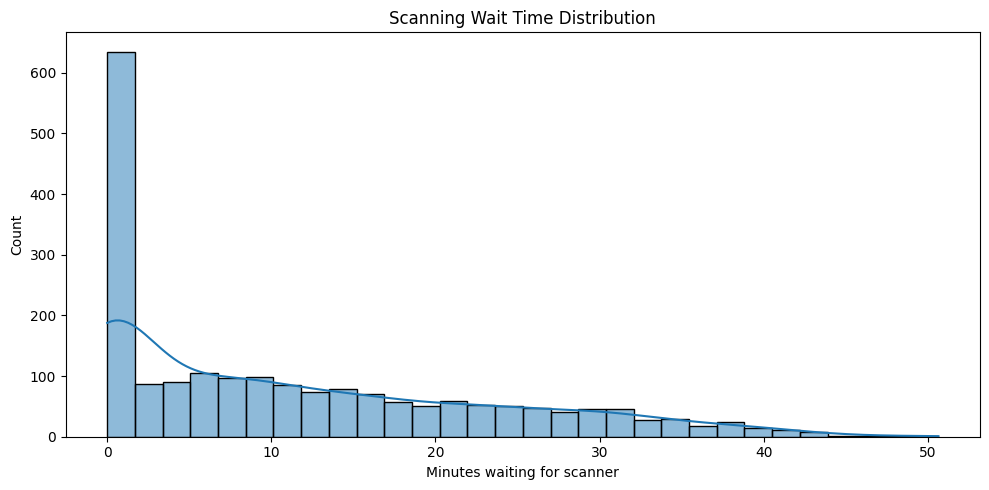

Saved: figures\run_20251229_143613\scan_wait.png


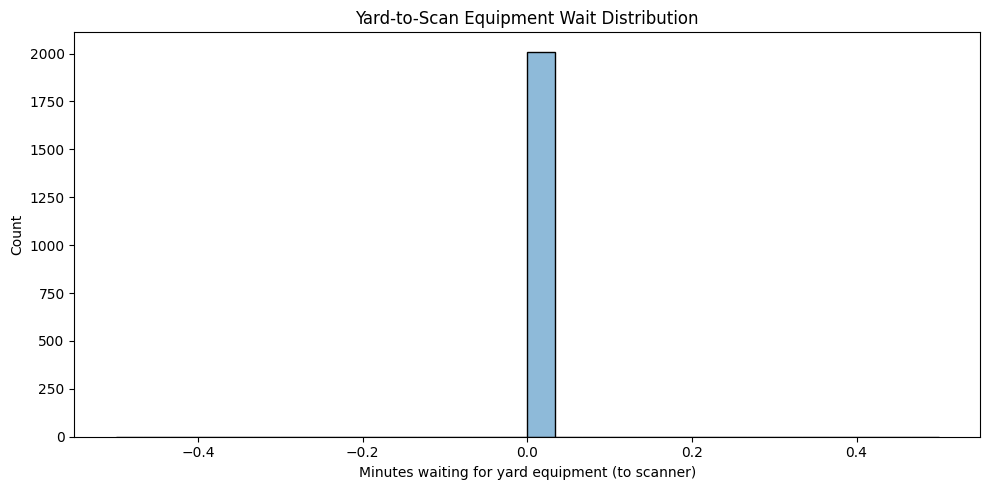

Saved: figures\run_20251229_143613\yard_to_scan_wait.png


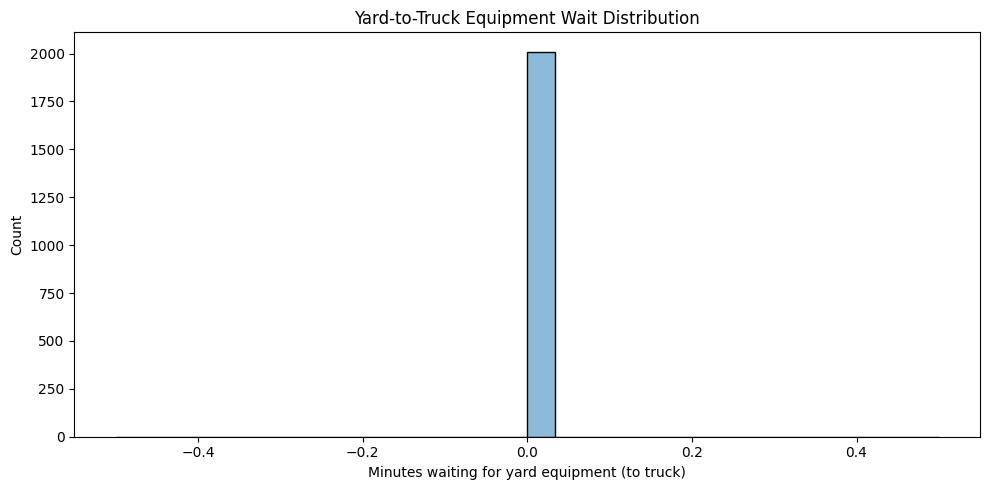

Saved: figures\run_20251229_143613\yard_to_truck_wait.png


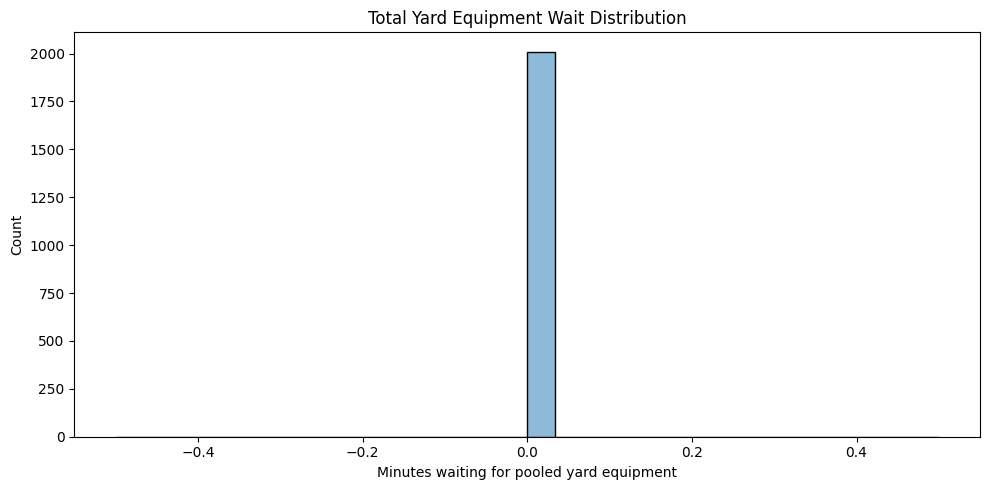

Saved: figures\run_20251229_143613\yard_equipment_wait.png


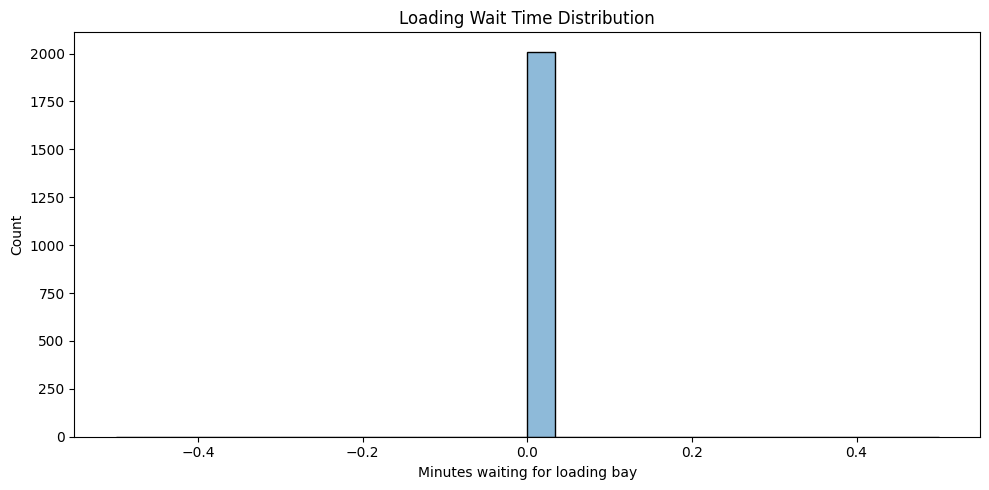

Saved: figures\run_20251229_143613\loading_wait.png


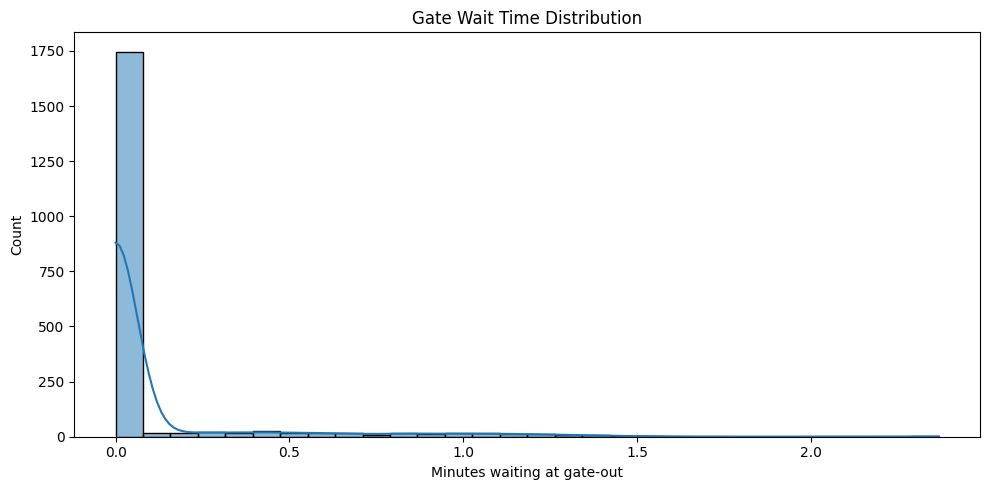

Saved: figures\run_20251229_143613\gate_wait.png


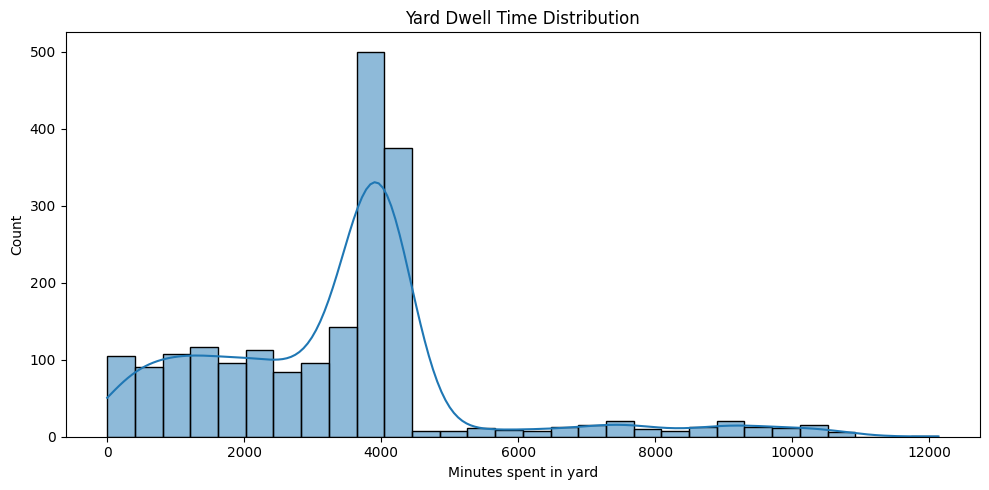

Saved: figures\run_20251229_143613\yard_dwell.png


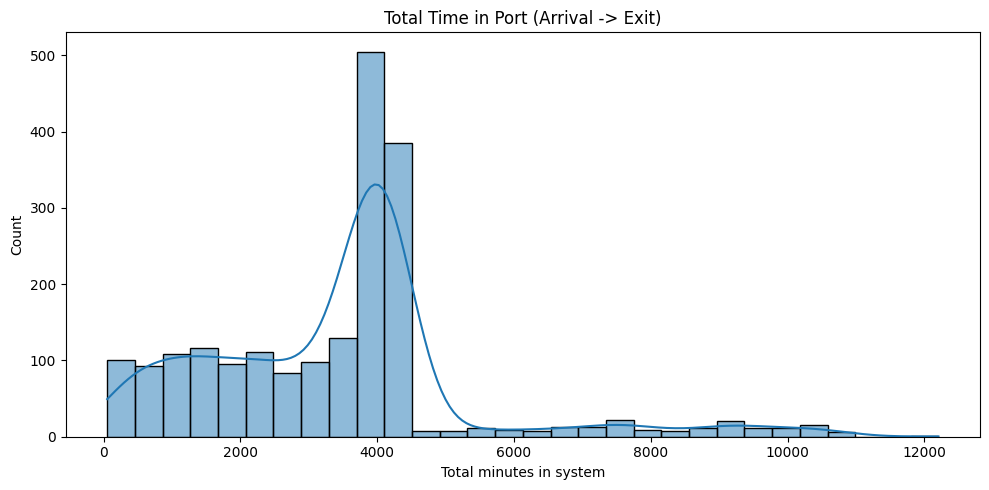

Saved: figures\run_20251229_143613\total_time.png


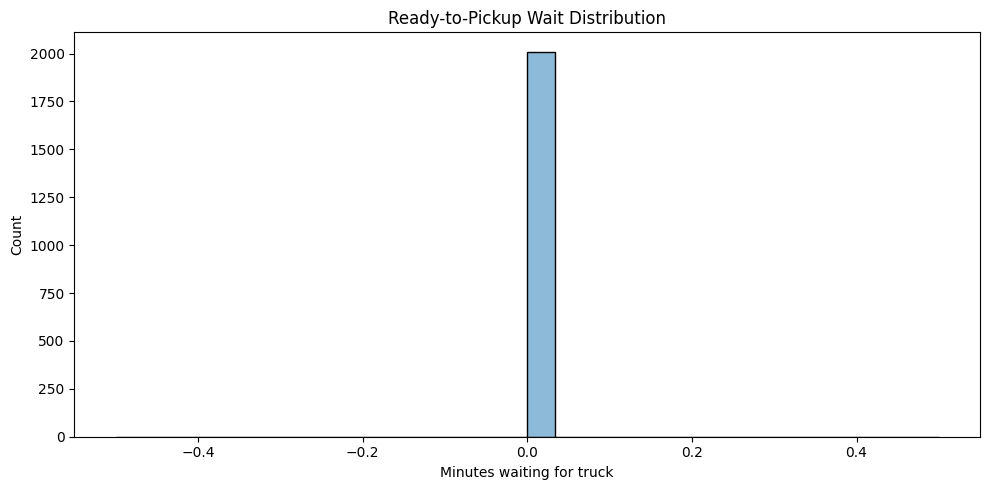

Saved: figures\run_20251229_143613\ready_to_pickup_wait.png


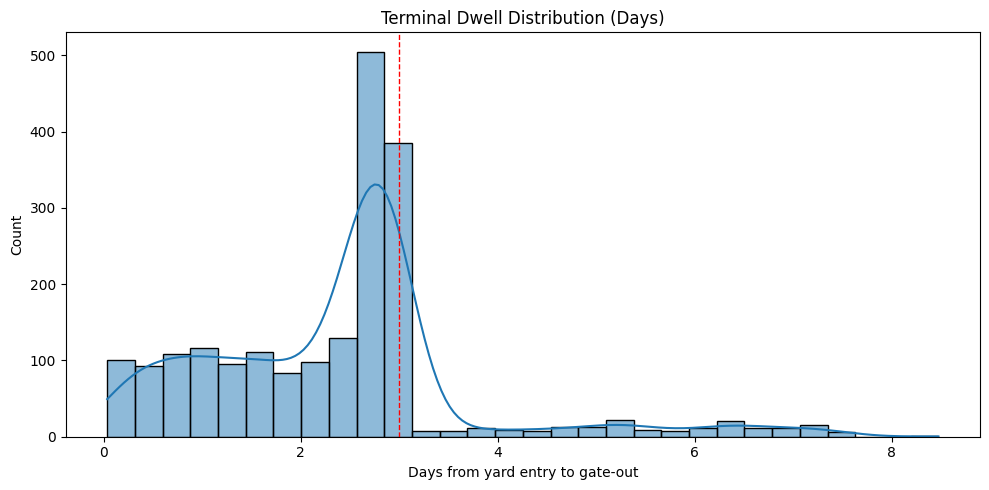

Saved: figures\run_20251229_143613\dwell_terminal_days.png


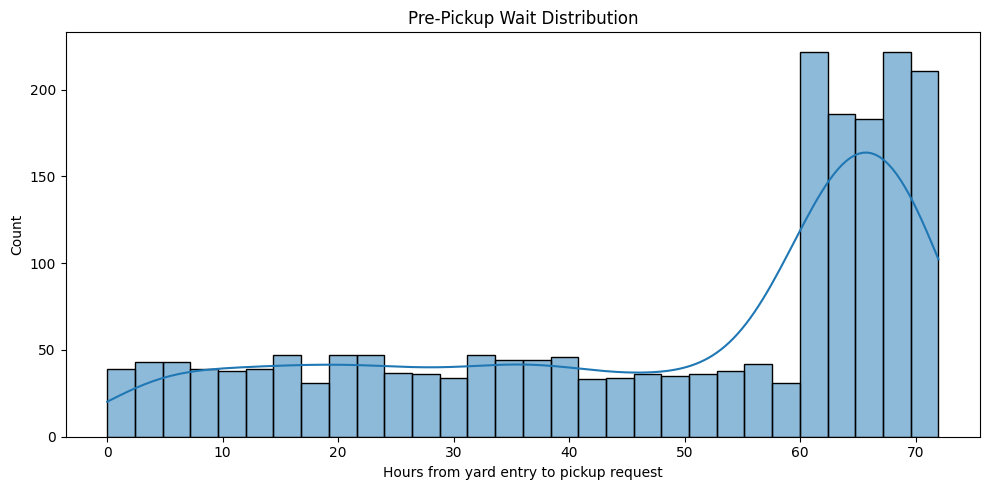

Saved: figures\run_20251229_143613\pre_pickup_wait_hours.png


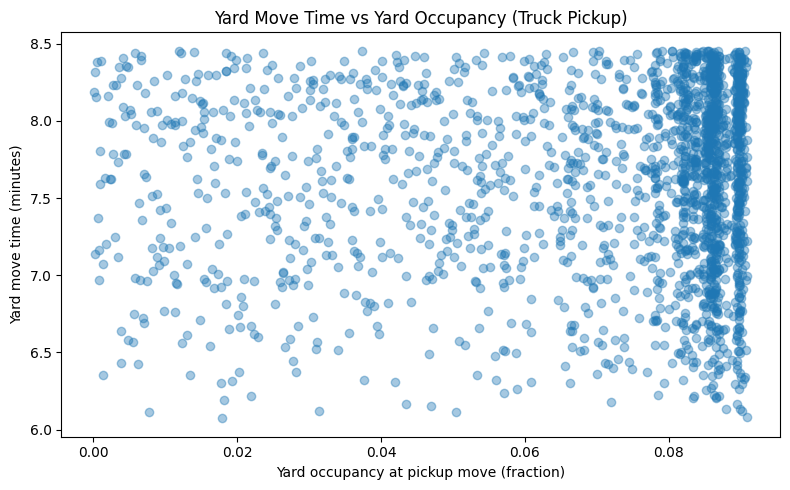

Saved: figures\run_20251229_143613\yard_move_vs_occupancy.png


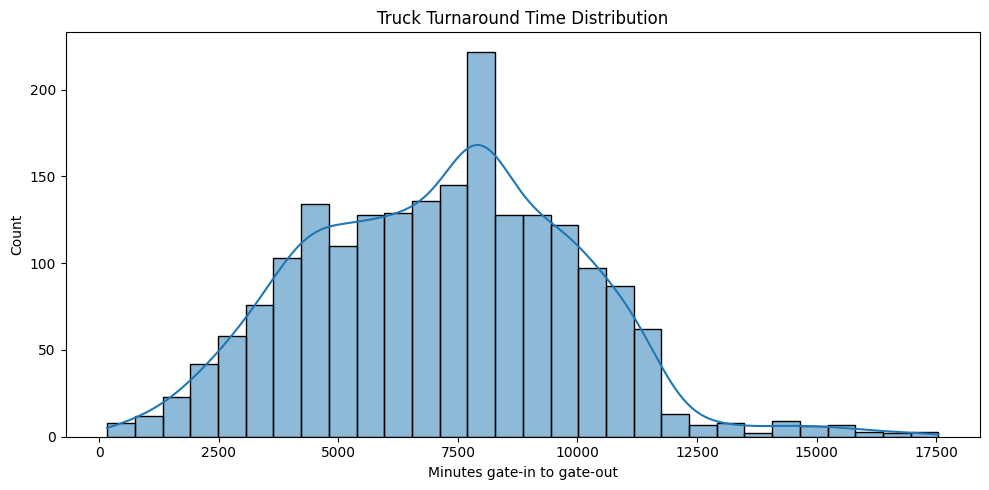

Saved: figures\run_20251229_143613\truck_turnaround.png


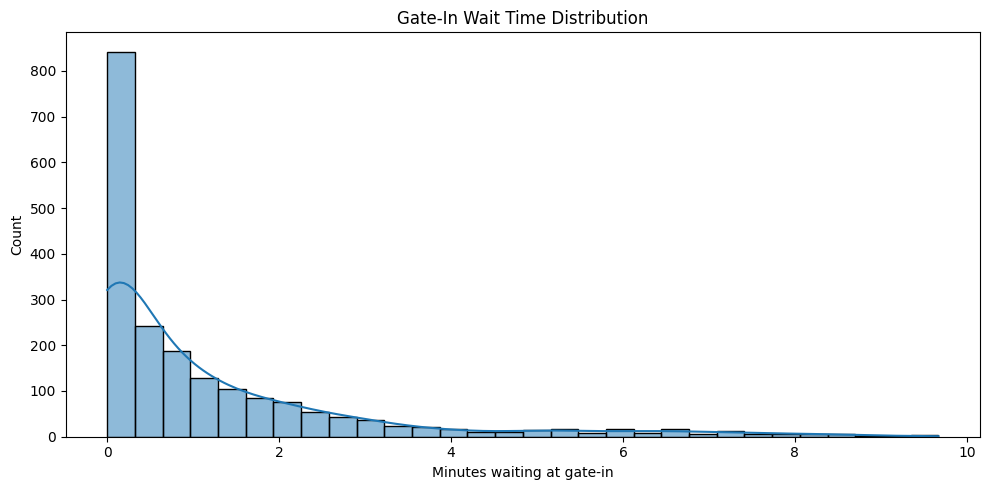

Saved: figures\run_20251229_143613\gate_in_wait.png


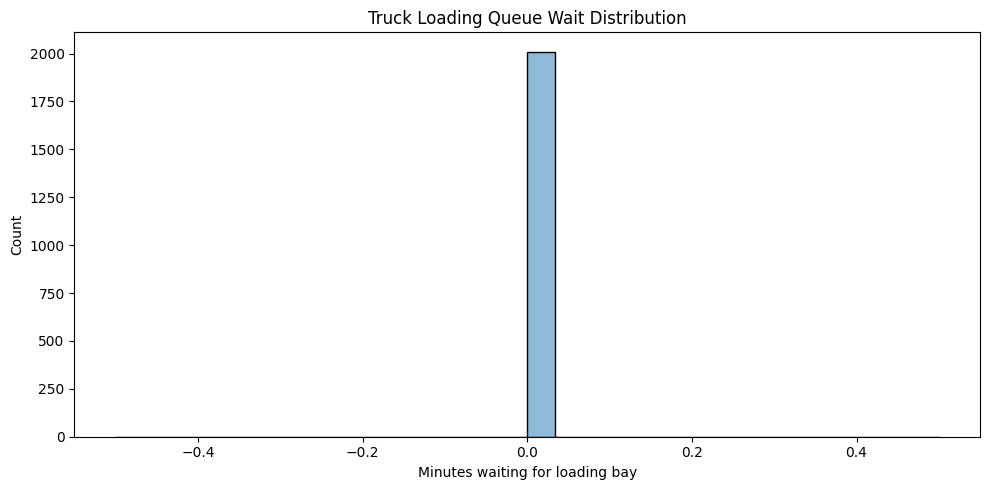

Saved: figures\run_20251229_143613\truck_loading_wait.png


In [10]:
# -----------------------------------------
# Plot metrics and save figures per run
# -----------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime as dt

df = metrics_to_dataframe()
df_trucks = truck_metrics_to_dataframe()

# Skip if nothing to plot
if df.empty and df_trucks.empty:
    print("No completed containers or trucks to plot yet.")
else:
    # Create a per-run folder
    run_stamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    fig_dir = Path("figures") / f"run_{run_stamp}"
    fig_dir.mkdir(parents=True, exist_ok=True)

    def plot_metric(data, column, title, xlabel, filename, nonnegative=False):
        if data.empty:
            print(f"Skipping {column}: dataframe empty.")
            return
        if column not in data.columns:
            print(f"Skipping {column}: column not found.")
            return
        series = data[column].dropna()
        if nonnegative:
            series = series[series >= 0]
        if series.empty:
            print(f"Skipping {column}: no non-negative values.")
            return
        plt.figure(figsize=(10, 5))
        sns.histplot(series, kde=True, bins=30)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Count")
        out = fig_dir / filename
        plt.tight_layout()
        plt.savefig(out, dpi=150)
        plt.show()
        print(f"Saved: {out}")

    # Container-level plots
    plot_metric(df, "scan_wait",
                "Scanning Wait Time Distribution",
                "Minutes waiting for scanner",
                "scan_wait.png")

    plot_metric(df, "yard_to_scan_wait",
                "Yard-to-Scan Equipment Wait Distribution",
                "Minutes waiting for yard equipment (to scanner)",
                "yard_to_scan_wait.png",
                nonnegative=True)

    plot_metric(df, "yard_to_truck_wait",
                "Yard-to-Truck Equipment Wait Distribution",
                "Minutes waiting for yard equipment (to truck)",
                "yard_to_truck_wait.png",
                nonnegative=True)

    plot_metric(df, "yard_equipment_wait",
                "Total Yard Equipment Wait Distribution",
                "Minutes waiting for pooled yard equipment",
                "yard_equipment_wait.png",
                nonnegative=True)

    plot_metric(df, "loading_wait",
                "Loading Wait Time Distribution",
                "Minutes waiting for loading bay",
                "loading_wait.png")

    plot_metric(df, "gate_wait",
                "Gate Wait Time Distribution",
                "Minutes waiting at gate-out",
                "gate_wait.png")

    plot_metric(df, "yard_dwell",
                "Yard Dwell Time Distribution",
                "Minutes spent in yard",
                "yard_dwell.png")

    plot_metric(df, "total_time",
                "Total Time in Port (Arrival -> Exit)",
                "Total minutes in system",
                "total_time.png")

    plot_metric(df, "ready_to_pickup_wait",
                "Ready-to-Pickup Wait Distribution",
                "Minutes waiting for truck",
                "ready_to_pickup_wait.png")

    # Dwell distribution in days with 72h reference line (3 days).
    if not df.empty and "dwell_terminal_days" in df.columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(df["dwell_terminal_days"], kde=True, bins=30)
        plt.axvline(3, color="red", linestyle="--", linewidth=1)
        # 72-hour free-time reference to show deadline clustering.
        plt.title("Terminal Dwell Distribution (Days)")
        plt.xlabel("Days from yard entry to gate-out")
        plt.ylabel("Count")
        out = fig_dir / "dwell_terminal_days.png"
        plt.tight_layout()
        plt.savefig(out, dpi=150)
        plt.show()
        print(f"Saved: {out}")

    # Pre-pickup wait distribution (hours).
    plot_metric(df, "pre_pickup_wait_hours",
                "Pre-Pickup Wait Distribution",
                "Hours from yard entry to pickup request",
                "pre_pickup_wait_hours.png")

    # Yard move time vs occupancy (optional diagnostic).
    if (not df.empty and
            "occupancy_at_yard_to_truck" in df.columns and
            "yard_to_truck_start" in df.columns and
            "yard_to_truck_end" in df.columns):
        scatter_df = df[["occupancy_at_yard_to_truck", "yard_to_truck_start", "yard_to_truck_end"]].dropna()
        if not scatter_df.empty:
            scatter_df["yard_to_truck_move_time"] = (
                scatter_df["yard_to_truck_end"] - scatter_df["yard_to_truck_start"]
            ).clip(lower=0)
            scatter_df = scatter_df[scatter_df["occupancy_at_yard_to_truck"] >= 0]
            if not scatter_df.empty:
                plt.figure(figsize=(8, 5))
                plt.scatter(
                    scatter_df["occupancy_at_yard_to_truck"],
                    scatter_df["yard_to_truck_move_time"],
                    alpha=0.4
                )
                plt.title("Yard Move Time vs Yard Occupancy (Truck Pickup)")
                plt.xlabel("Yard occupancy at pickup move (fraction)")
                plt.ylabel("Yard move time (minutes)")
                out = fig_dir / "yard_move_vs_occupancy.png"
                plt.tight_layout()
                plt.savefig(out, dpi=150)
                plt.show()
                print(f"Saved: {out}")

    # Truck-level plots
    plot_metric(df_trucks, "ttt_total",
                "Truck Turnaround Time Distribution",
                "Minutes gate-in to gate-out",
                "truck_turnaround.png")

    plot_metric(df_trucks, "gate_in_wait",
                "Gate-In Wait Time Distribution",
                "Minutes waiting at gate-in",
                "gate_in_wait.png")

    plot_metric(df_trucks, "loading_wait",
                "Truck Loading Queue Wait Distribution",
                "Minutes waiting for loading bay",
                "truck_loading_wait.png")


**What this does**
- Regenerates `df` from completed containers; skips plotting if empty.
- Creates a timestamped folder under `figures/run_YYYYMMDD_HHMMSS` for this run.
- Plots histograms (with KDE) for scan, loading, and gate waits; saves each PNG into the run folder and reports the saved paths.


# Baseline Seaside Productivity Diagnostics

In [11]:
minutes_per_hour = 60

crane_throughput = NUM_CRANES * (minutes_per_hour / CRANE_TIME)
scanner_throughput = NUM_SCANNERS * (minutes_per_hour / SCAN_TIME)

# Average effective loading rate from observed data
avg_loading_time = df["loading_wait"].mean() + df["loading_wait"].median()
loading_throughput = NUM_LOADING_BAYS * (minutes_per_hour / sample_loading_time())

print("Baseline Throughput Capacity (containers/hour)")
print(f"Crane throughput:    {round(crane_throughput, 1)}")
print(f"Scanner throughput:  {round(scanner_throughput, 1)}")
print(f"Loading throughput:  ~{round(loading_throughput, 1)}")

Baseline Throughput Capacity (containers/hour)
Crane throughput:    288.0
Scanner throughput:  12.0
Loading throughput:  ~49.3


# Improved Dwell Container Process

In [12]:
# -----------------------------------------
# Run Improved Dwell Simulation (Realistic)
# -----------------------------------------

# Reset metrics for improved run
METRICS_IMPROVED = []
TRUCK_METRICS_IMPROVED = []

# Custom record functions for improved dwell run
def record_metrics_improved(container_id, timestamps):
    METRICS_IMPROVED.append({
        "container_id": container_id,
        **timestamps
    })


def record_truck_metrics_improved(truck_id, timestamps):
    TRUCK_METRICS_IMPROVED.append({
        "truck_id": truck_id,
        **timestamps
    })


# ---------------------------------------------------
# Create environment for improved dwell simulation
# ---------------------------------------------------
env2 = simpy.Environment()

# Truck arrival profile (uses processed unit volume data)
# Keep the same calibrated loading capacity logic for comparability.
hourly_teu_rate2, truck_teu_rate_fn2 = load_teu_arrival_profile(
    path=TRUCK_ARRIVAL_DATA_PATH,
    facility_code=TRUCK_ARRIVAL_FACILITY,
    category_filter=TRUCK_ARRIVAL_CATEGORY,
    report_month=TRUCK_ARRIVAL_REPORT_MONTH,
)

NUM_LOADING_BAYS = estimate_required_loading_bays(hourly_teu_rate2, NUM_LOADING_BAYS)
print(f"Calibrated NUM_LOADING_BAYS (improved): {NUM_LOADING_BAYS}")

# Tune rebooking thresholds to resource scale after calibration.
QUEUE_THRESHOLD_SCANNER = max(5, int(4 * NUM_SCANNERS))
QUEUE_THRESHOLD_LOADER = max(5, int(0.1 * NUM_LOADING_BAYS))
print(f"Queue thresholds (scanner/loader, improved): {QUEUE_THRESHOLD_SCANNER} / {QUEUE_THRESHOLD_LOADER}")

cranes2 = simpy.Resource(env2, capacity=NUM_CRANES)
yard2 = simpy.Container(env2, capacity=YARD_CAPACITY, init=0)
yard_equipment2 = simpy.Resource(env2, capacity=YARD_EQUIP_CAPACITY_EFFECTIVE)
scanners2 = simpy.Resource(env2, capacity=NUM_SCANNERS)
loaders2 = simpy.Resource(env2, capacity=NUM_LOADING_BAYS)
customs2 = simpy.Resource(env2, capacity=NUM_CUSTOMS_INSPECTION_BAYS)
gate_in2 = simpy.Resource(env2, capacity=NUM_GATE_IN_LANES)
gate_out2 = simpy.Resource(env2, capacity=NUM_GATE_OUT_LANES)
ready_store2 = simpy.FilterStore(env2)

# Start container and truck arrivals
env2.process(arrival_generator(env2, cranes2, yard2, yard_equipment2, scanners2, ready_store2, SIM_TIME, DWELL_PARAMS_IMP, loaders2, customs2))
env2.process(
    truck_arrival_generator(
        env2, gate_in2, ready_store2, loaders2, gate_out2, yard2, yard_equipment2,
        truck_teu_rate_fn2, SIM_TIME,
        record_metrics_improved, record_truck_metrics_improved
    )
)

# Run improved simulation
env2.run(until=SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)

print("Improved dwell simulation complete.")


C:\Users\nkany\AppData\Local\Temp\ipykernel_46828\4099553184.py:264: DtypeWarning: Columns (13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Calibrated NUM_LOADING_BAYS (improved): 23
Queue thresholds (scanner/loader, improved): 8 / 5


Improved dwell simulation complete.


# Convert improved metrics to dataframe

In [13]:
# -----------------------------------------
# Convert Improved Metrics to DataFrame
# -----------------------------------------


def metrics_to_dataframe_improved():
    return _metrics_to_dataframe(METRICS_IMPROVED)


def truck_metrics_to_dataframe_improved():
    return _truck_metrics_to_dataframe(TRUCK_METRICS_IMPROVED)


# A Peek at the Dataframe

In [14]:
df_improved = metrics_to_dataframe_improved()
df_trucks_improved = truck_metrics_to_dataframe_improved()
df_improved.head(10)


,container_id,arrival_time,teu_size,crane_start,crane_end,yard_entry_time,pickup_request_time,scanner_queue_len_at_pickup,loader_queue_len_at_pickup,yard_exit_time,...,loading_wait,gate_wait,pre_pickup_wait,customs_queue_wait,customs_inspection_time,customs_hold_delay,rebook_delay,yard_equipment_wait,dwell_terminal_days,pre_pickup_wait_hours
0,19,104.740484,1,104.740484,108.073817,108.073817,164.455355,0,0,164.455355,...,0.0,0.0,56.381537,NaN,NaN,NaN,NaN,0.0,0.078352,0.939692
1,18,98.112772,1,98.112772,101.446105,101.446105,222.290004,0,0,222.290004,...,0.0,0.0,120.843899,NaN,NaN,NaN,NaN,0.0,0.123858,2.014065
2,66,363.569244,1,363.569244,366.902577,366.902577,420.188792,0,0,420.188792,...,0.0,0.0,53.286215,NaN,NaN,NaN,NaN,0.0,0.077976,0.888104
3,22,125.289323,1,125.289323,128.622657,128.622657,553.841175,0,0,553.841175,...,0.0,0.0,425.218518,NaN,NaN,NaN,NaN,0.0,0.334790,7.086975
4,107,547.745659,1,547.745659,551.078993,551.078993,606.050468,0,0,606.050468,...,0.0,0.0,54.971475,NaN,NaN,NaN,NaN,0.0,0.067282,0.916191
5,8,24.975749,1,24.975749,28.309082,28.309082,651.803959,0,0,651.803959,...,0.0,0.0,623.494877,NaN,NaN,NaN,NaN,0.0,0.471795,10.391581
6,76,416.988099,2,416.988099,420.321432,420.321432,661.306442,0,0,661.306442,...,0.0,0.0,240.985010,NaN,NaN,NaN,NaN,0.0,0.201267,4.016417
7,77,426.351672,2,426.351672,429.685006,429.685006,748.203901,0,0,748.203901,...,0.0,0.0,318.518896,NaN,NaN,NaN,NaN,0.0,0.260491,5.308648
8,39,226.738324,1,226.738324,230.071658,230.071658,767.341992,0,0,767.341992,...,0.0,0.0,537.270334,NaN,NaN,NaN,NaN,0.0,0.404241,8.954506
9,54,294.542358,1,294.542358,297.875692,297.875692,775.870245,0,0,775.870245,...,0.0,0.0,477.994553,NaN,NaN,NaN,NaN,0.0,0.368908,7.966576


In [15]:
print_validation_summary("Improved", df_improved, df_trucks_improved)


Improved - Validation Summary
Truck turnaround (min) mean/median/p90: 6461.8 / 6688.2 / 9771.3
gate_in_wait mean (min): 1.0
loading_wait mean (min): 0.0
gate_out_wait mean (min): 0.1
ready_to_pickup_wait mean (min): 0.0
Note: These are student case-study calibration targets; not official operations.


In [16]:
def quality_checks(label, df):
    # Basic sanity checks to confirm non-empty data and no negative waits.
    print(f"{label} rows: {len(df)}")
    if df.empty:
        return

    wait_cols = [
        "scan_wait",
        "yard_to_scan_wait",
        "yard_to_truck_wait",
        "yard_equipment_wait",
        "loading_wait",
        "gate_wait",
        "pre_pickup_wait",
        "ready_to_pickup_wait",
        "customs_queue_wait",
        "customs_inspection_time",
        "customs_hold_delay",
        "rebook_delay",
    ]
    for col in wait_cols:
        if col in df.columns:
            print(f"{label} min {col}: {df[col].min():.2f}")

    if "pre_pickup_wait_hours" in df.columns:
        p50 = df["pre_pickup_wait_hours"].quantile(0.5)
        p90 = df["pre_pickup_wait_hours"].quantile(0.9)
        p99 = df["pre_pickup_wait_hours"].quantile(0.99)
        share_deadline = ((df["pre_pickup_wait_hours"] >= 60) & (df["pre_pickup_wait_hours"] <= 72)).mean()
        print(f"{label} pre_pickup_wait_hours p50/p90/p99: {p50:.1f} / {p90:.1f} / {p99:.1f}")
        print(f"{label} share in 60-72h window: {share_deadline:.2%}")

        target_deadline = DEADLINE_GROUP_PROB_BASE if label == "Baseline" else DEADLINE_GROUP_PROB_IMP
        if abs(share_deadline - target_deadline) > 0.05:
            print(f"{label} note: adjust DEADLINE_GROUP_PROB_* (target {target_deadline:.0%})")

    if "dwell_terminal_days" in df.columns:
        p50 = df["dwell_terminal_days"].quantile(0.5)
        p90 = df["dwell_terminal_days"].quantile(0.9)
        p99 = df["dwell_terminal_days"].quantile(0.99)
        print(f"{label} dwell_terminal_days p50/p90/p99: {p50:.1f} / {p90:.1f} / {p99:.1f}")

    # Summary for yard equipment wait and total time (required for verification).
    for col in ["yard_equipment_wait", "total_time"]:
        if col in df.columns:
            mean = df[col].mean()
            p50 = df[col].quantile(0.5)
            p90 = df[col].quantile(0.9)
            print(f"{label} {col} mean/p50/p90: {mean:.1f} / {p50:.1f} / {p90:.1f}")

    # Rates for calibration checks.
    if "customs_hold_delay" in df.columns:
        hold_rate = (df["customs_hold_delay"] > 0).mean()
        print(f"{label} customs hold rate: {hold_rate:.2%}")
        target_hold = CUSTOMS_HOLD_PROB_BASE if label == "Baseline" else CUSTOMS_HOLD_PROB_IMP
        if abs(hold_rate - target_hold) > 0.02:
            print(f"{label} note: adjust CUSTOMS_HOLD_PROB_* (target {target_hold:.0%})")
    if "rebook_delay" in df.columns:
        rebook_rate = (df["rebook_delay"] > 0).mean()
        print(f"{label} rebook rate: {rebook_rate:.2%}")

    # Queue length diagnostics for rebooking thresholds.
    if "scanner_queue_len_at_pickup" in df.columns:
        p90 = df["scanner_queue_len_at_pickup"].quantile(0.9)
        print(f"{label} scanner_queue_len_at_pickup p90: {p90:.0f}")
        if p90 < (QUEUE_THRESHOLD_SCANNER * 0.5):
            print(f"{label} note: consider lowering QUEUE_THRESHOLD_SCANNER")
        if p90 > QUEUE_THRESHOLD_SCANNER:
            print(f"{label} note: consider raising QUEUE_THRESHOLD_SCANNER")

    if "loader_queue_len_at_pickup" in df.columns:
        p90 = df["loader_queue_len_at_pickup"].quantile(0.9)
        print(f"{label} loader_queue_len_at_pickup p90: {p90:.0f}")
        if p90 < (QUEUE_THRESHOLD_LOADER * 0.5):
            print(f"{label} note: consider lowering QUEUE_THRESHOLD_LOADER")
        if p90 > QUEUE_THRESHOLD_LOADER:
            print(f"{label} note: consider raising QUEUE_THRESHOLD_LOADER")


quality_checks("Baseline", df)
quality_checks("Improved", df_improved)


Baseline rows: 2010
Baseline min scan_wait: 0.00
Baseline min yard_to_scan_wait: 0.00
Baseline min yard_to_truck_wait: 0.00
Baseline min yard_equipment_wait: 0.00
Baseline min loading_wait: 0.00
Baseline min gate_wait: 0.00
Baseline min pre_pickup_wait: 0.05
Baseline min ready_to_pickup_wait: 0.00
Baseline min customs_queue_wait: 0.00
Baseline min customs_inspection_time: 34.41
Baseline min customs_hold_delay: 3004.24
Baseline min rebook_delay: 810.66
Baseline pre_pickup_wait_hours p50/p90/p99: 60.2 / 69.7 / 71.7
Baseline share in 60-72h window: 50.95%
Baseline dwell_terminal_days p50/p90/p99: 2.6 / 3.0 / 7.1
Baseline yard_equipment_wait mean/p50/p90: 0.0 / 0.0 / 0.0
Baseline total_time mean/p50/p90: 3413.9 / 3746.1 / 4375.8
Baseline customs hold rate: 8.61%
Baseline rebook rate: 2.29%
Baseline scanner_queue_len_at_pickup p90: 6
Baseline loader_queue_len_at_pickup p90: 0
Baseline note: consider lowering QUEUE_THRESHOLD_LOADER
Improved rows: 1968
Improved min scan_wait: 0.00
Improved mi

# Side-by-Side Comparison Plots

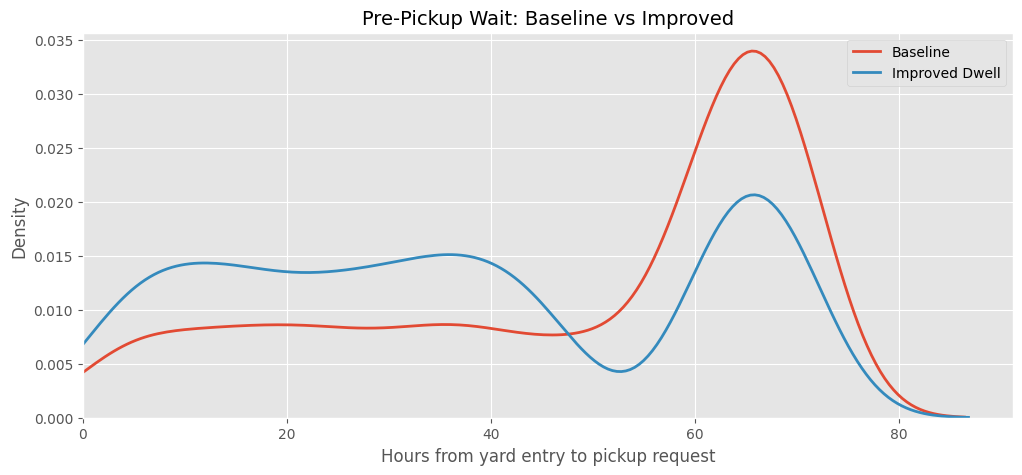

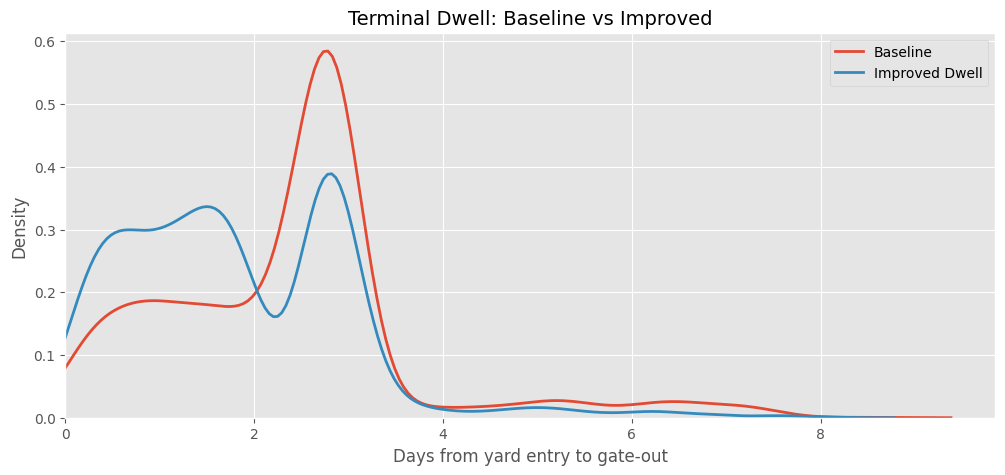

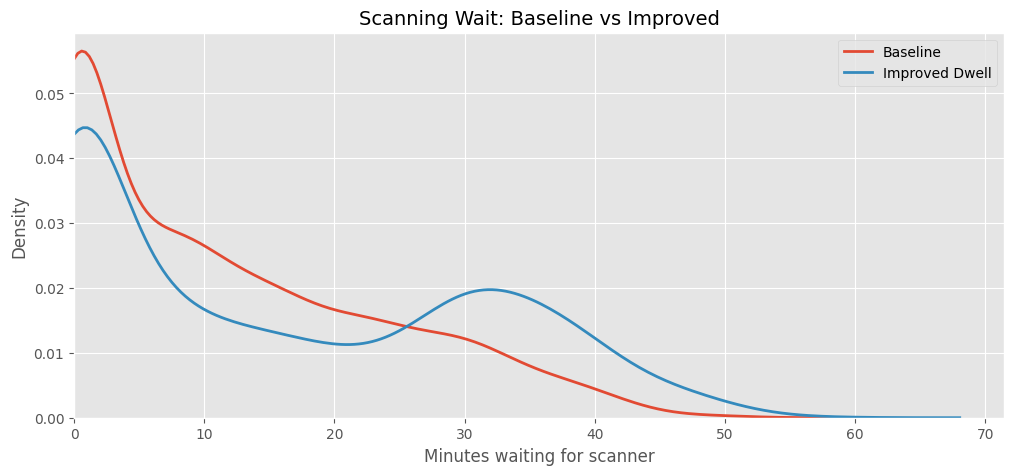

C:\Users\nkany\AppData\Local\Temp\ipykernel_46828\1034886577.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df1[column], label="Baseline", linewidth=2, clip=(0, None))
C:\Users\nkany\AppData\Local\Temp\ipykernel_46828\1034886577.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df2[column], label="Improved Dwell", linewidth=2, clip=(0, None))
C:\Users\nkany\AppData\Local\Temp\ipykernel_46828\1034886577.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


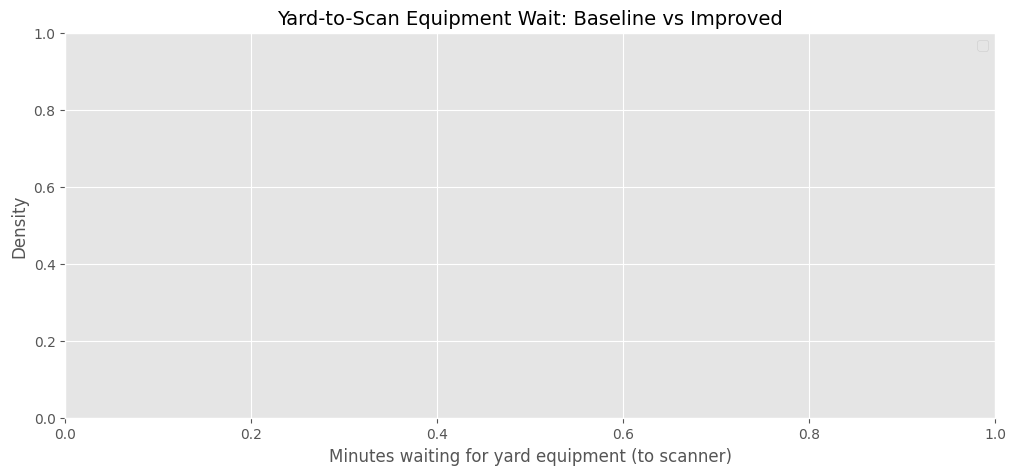

C:\Users\nkany\AppData\Local\Temp\ipykernel_46828\1034886577.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df1[column], label="Baseline", linewidth=2, clip=(0, None))
C:\Users\nkany\AppData\Local\Temp\ipykernel_46828\1034886577.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df2[column], label="Improved Dwell", linewidth=2, clip=(0, None))
C:\Users\nkany\AppData\Local\Temp\ipykernel_46828\1034886577.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


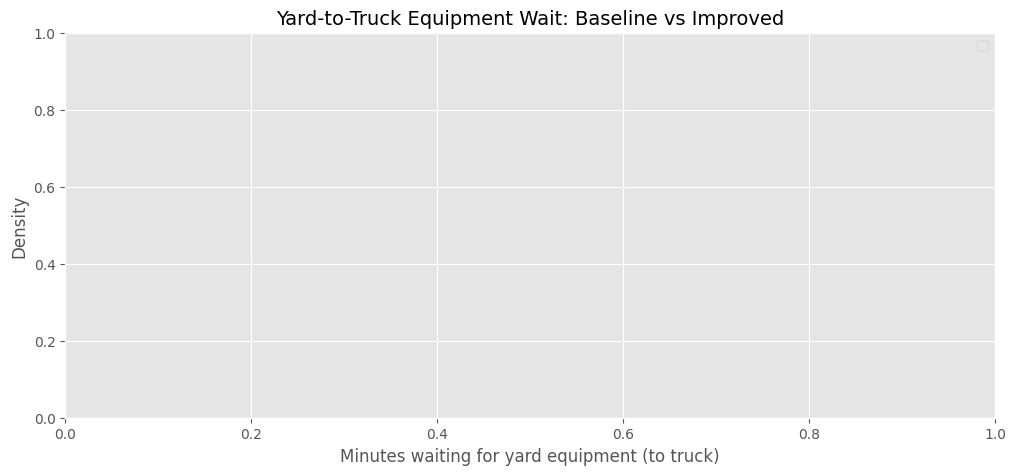

C:\Users\nkany\AppData\Local\Temp\ipykernel_46828\1034886577.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df1[column], label="Baseline", linewidth=2, clip=(0, None))


C:\Users\nkany\AppData\Local\Temp\ipykernel_46828\1034886577.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df2[column], label="Improved Dwell", linewidth=2, clip=(0, None))
C:\Users\nkany\AppData\Local\Temp\ipykernel_46828\1034886577.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


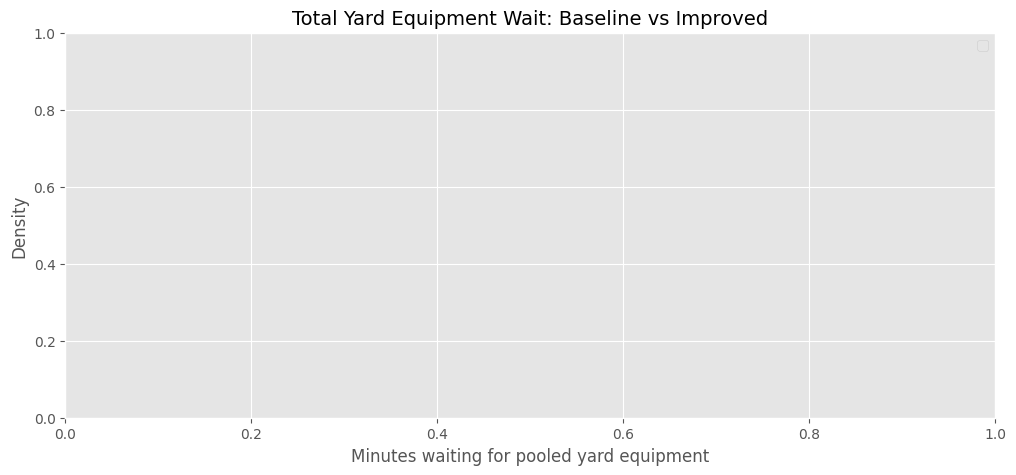

C:\Users\nkany\AppData\Local\Temp\ipykernel_46828\1034886577.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df1[column], label="Baseline", linewidth=2, clip=(0, None))
C:\Users\nkany\AppData\Local\Temp\ipykernel_46828\1034886577.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df2[column], label="Improved Dwell", linewidth=2, clip=(0, None))
C:\Users\nkany\AppData\Local\Temp\ipykernel_46828\1034886577.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


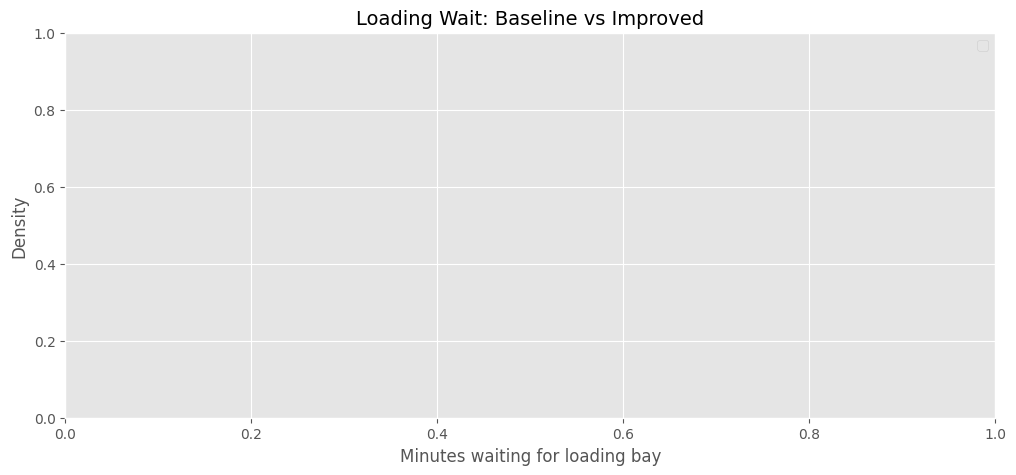

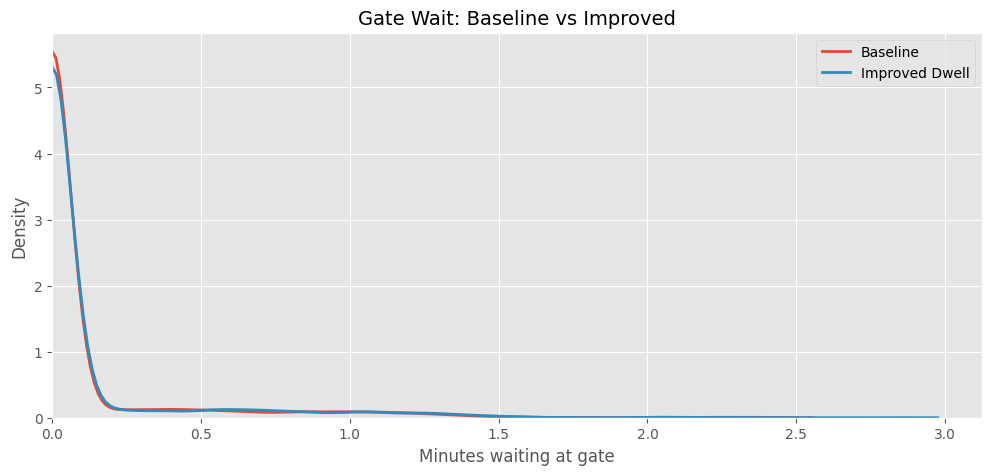

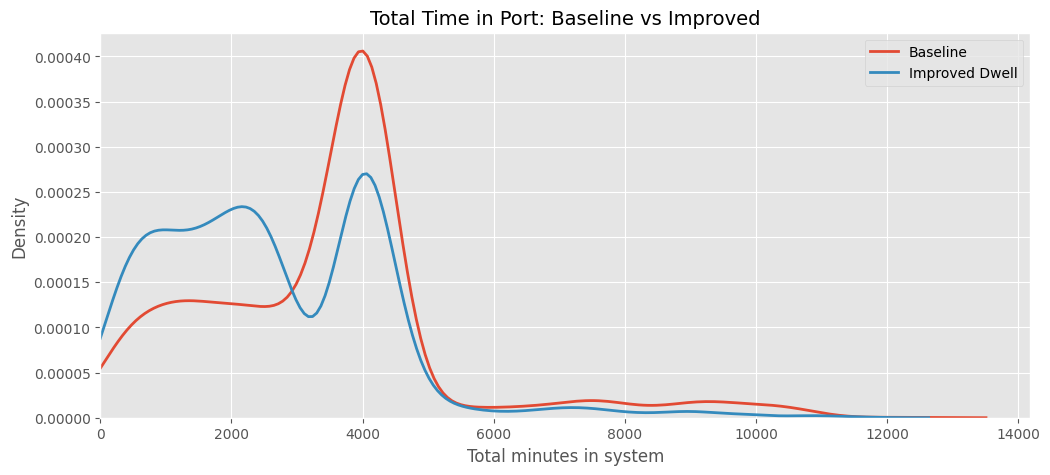

In [17]:
# -----------------------------------------
# Compare Baseline vs Improved Dwell
# -----------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

def compare_distributions(df1, df2, column, title, xlabel):
    if column not in df1.columns or column not in df2.columns:
        print(f"Skipping {column}: missing in dataframe.")
        return

    plt.figure(figsize=(12,5))

    # Clip KDE to non-negative domain (the correct domain for waits)
    sns.kdeplot(df1[column], label="Baseline", linewidth=2, clip=(0, None))
    sns.kdeplot(df2[column], label="Improved Dwell", linewidth=2, clip=(0, None))

    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.xlim(left=0)   # Force the X-axis to start at 0
    plt.legend()
    plt.show()


# ------- Required comparisons -------

compare_distributions(df, df_improved,
                      "pre_pickup_wait_hours",
                      "Pre-Pickup Wait: Baseline vs Improved",
                      "Hours from yard entry to pickup request")

compare_distributions(df, df_improved,
                      "dwell_terminal_days",
                      "Terminal Dwell: Baseline vs Improved",
                      "Days from yard entry to gate-out")

compare_distributions(df, df_improved,
                      "scan_wait",
                      "Scanning Wait: Baseline vs Improved",
                      "Minutes waiting for scanner")

compare_distributions(df, df_improved,
                      "yard_to_scan_wait",
                      "Yard-to-Scan Equipment Wait: Baseline vs Improved",
                      "Minutes waiting for yard equipment (to scanner)")

compare_distributions(df, df_improved,
                      "yard_to_truck_wait",
                      "Yard-to-Truck Equipment Wait: Baseline vs Improved",
                      "Minutes waiting for yard equipment (to truck)")

compare_distributions(df, df_improved,
                      "yard_equipment_wait",
                      "Total Yard Equipment Wait: Baseline vs Improved",
                      "Minutes waiting for pooled yard equipment")

compare_distributions(df, df_improved,
                      "loading_wait",
                      "Loading Wait: Baseline vs Improved",
                      "Minutes waiting for loading bay")

compare_distributions(df, df_improved,
                      "gate_wait",
                      "Gate Wait: Baseline vs Improved",
                      "Minutes waiting at gate")

compare_distributions(df, df_improved,
                      "total_time",
                      "Total Time in Port: Baseline vs Improved",
                      "Total minutes in system")


### **Comparison: Baseline vs Improved Yard Dwell**

These plots compare the baseline simulation and the improved-dwell simulation.

The goal is to show how reducing yard dwell time affects:

- overall throughput  
- queue lengths  
- system congestion  
- end-to-end transit time  



#### **1. Yard Dwell**
This should show a significant left-shift (shorter dwell times).

#### **2. Scanning Wait**
Reduced yard congestion allows containers to reach scanning earlier.

#### **3. Loading Wait**
Lower yard occupancy improves container accessibility for loading.

#### **4. Gate Wait**
Gate-out is fast, but improvements upstream reduce peaks.

#### **5. Total Time in System**
This is the most important KPI —  
a large reduction here validates operational impact.

These will form the graphs used in the report and presentation.


# Compute Numerical Improvements

In [18]:
# -----------------------------------------
# Numerical Performance Improvements
# -----------------------------------------

def percentage_change(before, after):
    """Percent reduction; handles zero to avoid divide-by-zero warnings."""
    # Normalize to plain floats to avoid np.float64 in output.
    before = float(before)
    after = float(after)
    if before == 0:
        if after == 0:
            return 0.0
        return float('nan')
    return float(round(((before - after) / before) * 100, 2))

results = {}

# Mean values
results["Mean Total Time Reduction (%)"] = percentage_change(
    df["total_time"].mean(),
    df_improved["total_time"].mean()
)

results["Mean Yard Dwell Reduction (%)"] = percentage_change(
    df["yard_dwell"].mean(),
    df_improved["yard_dwell"].mean()
)

results["Mean Scanning Wait Reduction (%)"] = percentage_change(
    df["scan_wait"].mean(),
    df_improved["scan_wait"].mean()
)

results["Mean Loading Wait Reduction (%)"] = percentage_change(
    df["loading_wait"].mean(),
    df_improved["loading_wait"].mean()
)

results["Mean Gate Wait Reduction (%)"] = percentage_change(
    df["gate_wait"].mean(),
    df_improved["gate_wait"].mean()
)

results


{'Mean Total Time Reduction (%)': 23.45,
 'Mean Yard Dwell Reduction (%)': 24.06,
 'Mean Scanning Wait Reduction (%)': -37.35,
 'Mean Loading Wait Reduction (%)': 0.0,
 'Mean Gate Wait Reduction (%)': -5.69}

### **Numerical Performance Improvements**

This table quantifies how much performance improves under the reduced dwell policy.

We measure:

- average total time in the port  
- average yard dwell time  
- average scanning wait  
- average loading wait  
- average gate wait  

Each is expressed as a **percentage reduction** relative to baseline.

This forms the core of your optimisation results for the report.


## Yard Equipment Stress Test (Crisis Capacity)

This stress run uses the SOURCE-ANCHORED crisis capacity range to test yard-equipment bottlenecks.


In [19]:
# -----------------------------------------
# Yard Equipment Stress Test (Crisis Capacity)
# -----------------------------------------

# SOURCE-ANCHORED range; midpoint used as a stress-test assumption.
crisis_capacity_mid = int(round(sum(YARD_EQUIP_CAPACITY_CRISIS_RANGE) / 2))
print(f"Crisis yard equipment capacity (midpoint): {crisis_capacity_mid}")

# Local metrics for stress run to avoid mixing with baseline/improved.
METRICS_STRESS = []
TRUCK_METRICS_STRESS = []

def record_metrics_stress(container_id, timestamps):
    """Append one container metrics row for the stress run."""
    METRICS_STRESS.append({"container_id": container_id, **timestamps})


def record_truck_metrics_stress(truck_id, timestamps):
    """Append one truck metrics row for the stress run."""
    TRUCK_METRICS_STRESS.append({"truck_id": truck_id, **timestamps})

env_stress = simpy.Environment()

# Use the same truck arrival profile for comparability.
hourly_teu_rate_stress, truck_teu_rate_fn_stress = load_teu_arrival_profile(
    path=TRUCK_ARRIVAL_DATA_PATH,
    facility_code=TRUCK_ARRIVAL_FACILITY,
    category_filter=TRUCK_ARRIVAL_CATEGORY,
    report_month=TRUCK_ARRIVAL_REPORT_MONTH,
)

num_loading_bays_stress = estimate_required_loading_bays(hourly_teu_rate_stress, NUM_LOADING_BAYS)
print(f"Calibrated NUM_LOADING_BAYS (stress): {num_loading_bays_stress}")

# Align rebooking thresholds with the stress-run loader capacity.
prev_scanner_threshold = QUEUE_THRESHOLD_SCANNER
prev_loader_threshold = QUEUE_THRESHOLD_LOADER
QUEUE_THRESHOLD_SCANNER = max(5, int(4 * NUM_SCANNERS))
QUEUE_THRESHOLD_LOADER = max(5, int(0.1 * num_loading_bays_stress))
print(f"Queue thresholds (stress): {QUEUE_THRESHOLD_SCANNER} / {QUEUE_THRESHOLD_LOADER}")

# Resources for the stress run.
cranes_s = simpy.Resource(env_stress, capacity=NUM_CRANES)
yard_s = simpy.Container(env_stress, capacity=YARD_CAPACITY, init=0)
yard_equipment_s = simpy.Resource(env_stress, capacity=crisis_capacity_mid)
scanners_s = simpy.Resource(env_stress, capacity=NUM_SCANNERS)
loaders_s = simpy.Resource(env_stress, capacity=num_loading_bays_stress)
customs_s = simpy.Resource(env_stress, capacity=NUM_CUSTOMS_INSPECTION_BAYS)
gate_in_s = simpy.Resource(env_stress, capacity=NUM_GATE_IN_LANES)
gate_out_s = simpy.Resource(env_stress, capacity=NUM_GATE_OUT_LANES)
ready_store_s = simpy.FilterStore(env_stress)

env_stress.process(
    arrival_generator(env_stress, cranes_s, yard_s, yard_equipment_s, scanners_s, ready_store_s,
                      SIM_TIME, DWELL_PARAMS_BASE, loaders_s, customs_s)
)
env_stress.process(
    truck_arrival_generator(
        env_stress, gate_in_s, ready_store_s, loaders_s, gate_out_s, yard_s, yard_equipment_s,
        truck_teu_rate_fn_stress, SIM_TIME,
        record_metrics_stress, record_truck_metrics_stress
    )
)

env_stress.run(until=SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)

# Restore thresholds after stress run to avoid side effects.
QUEUE_THRESHOLD_SCANNER = prev_scanner_threshold
QUEUE_THRESHOLD_LOADER = prev_loader_threshold

df_stress = _metrics_to_dataframe(METRICS_STRESS)
if df_stress.empty:
    print("Stress run produced no completed containers.")
else:
    if "yard_equipment_wait" in df_stress.columns:
        s = df_stress["yard_equipment_wait"].dropna()
        print(
            "Stress yard_equipment_wait mean/p50/p90: "
            f"{s.mean():.1f} / {s.quantile(0.5):.1f} / {s.quantile(0.9):.1f}"
        )
    if "total_time" in df_stress.columns:
        t = df_stress["total_time"].dropna()
        print(
            "Stress total_time mean/p50/p90: "
            f"{t.mean():.1f} / {t.quantile(0.5):.1f} / {t.quantile(0.9):.1f}"
        )


Crisis yard equipment capacity (midpoint): 52


C:\Users\nkany\AppData\Local\Temp\ipykernel_46828\4099553184.py:264: DtypeWarning: Columns (13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Calibrated NUM_LOADING_BAYS (stress): 23
Queue thresholds (stress): 8 / 5


Stress yard_equipment_wait mean/p50/p90: 0.0 / 0.0 / 0.0
Stress total_time mean/p50/p90: 3484.3 / 3774.3 / 4887.0


## Yard Equipment Sensitivity (Availability Sweep)

Availability is varied to expose bottlenecks; arrival rates are held constant for comparability.


In [20]:
# -----------------------------------------
# Yard Equipment Sensitivity (Availability Sweep)
# -----------------------------------------

# ASSUMPTION TO TUNE: shorter run to keep sensitivity scans fast.
SENSITIVITY_SIM_DAYS = 1
SENSITIVITY_SIM_TIME = SENSITIVITY_SIM_DAYS * 24 * 60

# ASSUMPTION TO TUNE: scale arrivals to expose yard-equipment bottlenecks.
ARRIVAL_RATE_MULTIPLIER_SENS = 10
SENS_CONTAINER_INTERARRIVAL_MEAN = 5 / ARRIVAL_RATE_MULTIPLIER_SENS

# ASSUMPTION TO TUNE: availability targets for sensitivity.
AVAIL_TARGETS = [0.20, 0.30, 0.40, 0.59]

# Keep the same arrival profile for each availability level.
hourly_teu_rate_sens, truck_teu_rate_fn_sens = load_teu_arrival_profile(
    path=TRUCK_ARRIVAL_DATA_PATH,
    facility_code=TRUCK_ARRIVAL_FACILITY,
    category_filter=TRUCK_ARRIVAL_CATEGORY,
    report_month=TRUCK_ARRIVAL_REPORT_MONTH,
)
hourly_teu_rate_sens_scaled = [rate * ARRIVAL_RATE_MULTIPLIER_SENS for rate in hourly_teu_rate_sens]
num_loading_bays_sens = estimate_required_loading_bays(hourly_teu_rate_sens_scaled, NUM_LOADING_BAYS)

def truck_teu_rate_fn_sens_scaled(t_min):
    """Scale truck arrival rates for sensitivity stress testing."""
    return truck_teu_rate_fn_sens(t_min) * ARRIVAL_RATE_MULTIPLIER_SENS

sensitivity_rows = []

for avail in AVAIL_TARGETS:
    capacity_effective = max(1, round(YARD_EQUIP_CAPACITY_NOMINAL * avail))

    # Local metrics for this availability level.
    metrics_level = []
    truck_metrics_level = []

    def record_metrics_level(container_id, timestamps):
        """Append one container metrics row for the sensitivity run."""
        metrics_level.append({"container_id": container_id, **timestamps})

    def record_truck_metrics_level(truck_id, timestamps):
        """Append one truck metrics row for the sensitivity run."""
        truck_metrics_level.append({"truck_id": truck_id, **timestamps})

    env_sens = simpy.Environment()

    # Align rebooking thresholds with the sensitivity loader capacity.
    prev_scanner_threshold = QUEUE_THRESHOLD_SCANNER
    prev_loader_threshold = QUEUE_THRESHOLD_LOADER
    QUEUE_THRESHOLD_SCANNER = max(5, int(4 * NUM_SCANNERS))
    QUEUE_THRESHOLD_LOADER = max(5, int(0.1 * num_loading_bays_sens))

    cranes_s = simpy.Resource(env_sens, capacity=NUM_CRANES)
    yard_s = simpy.Container(env_sens, capacity=YARD_CAPACITY, init=0)
    yard_equipment_s = simpy.Resource(env_sens, capacity=capacity_effective)
    scanners_s = simpy.Resource(env_sens, capacity=NUM_SCANNERS)
    loaders_s = simpy.Resource(env_sens, capacity=num_loading_bays_sens)
    customs_s = simpy.Resource(env_sens, capacity=NUM_CUSTOMS_INSPECTION_BAYS)
    gate_in_s = simpy.Resource(env_sens, capacity=NUM_GATE_IN_LANES)
    gate_out_s = simpy.Resource(env_sens, capacity=NUM_GATE_OUT_LANES)
    ready_store_s = simpy.FilterStore(env_sens)

    env_sens.process(
        arrival_generator(env_sens, cranes_s, yard_s, yard_equipment_s, scanners_s, ready_store_s,
                          SENSITIVITY_SIM_TIME, DWELL_PARAMS_BASE, loaders_s, customs_s,
                          interarrival_mean=SENS_CONTAINER_INTERARRIVAL_MEAN)
    )
    env_sens.process(
        truck_arrival_generator(
            env_sens, gate_in_s, ready_store_s, loaders_s, gate_out_s, yard_s, yard_equipment_s,
            truck_teu_rate_fn_sens_scaled, SENSITIVITY_SIM_TIME,
            record_metrics_level, record_truck_metrics_level
        )
    )

    env_sens.run(until=SENSITIVITY_SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)

    # Restore thresholds after this run.
    QUEUE_THRESHOLD_SCANNER = prev_scanner_threshold
    QUEUE_THRESHOLD_LOADER = prev_loader_threshold

    df_level = _metrics_to_dataframe(metrics_level)
    if df_level.empty:
        print(f"No completed containers for availability {avail:.2f}")
        continue

    yard_wait = df_level["yard_equipment_wait"].dropna() if "yard_equipment_wait" in df_level.columns else pd.Series(dtype=float)
    total_time = df_level["total_time"].dropna() if "total_time" in df_level.columns else pd.Series(dtype=float)

    sensitivity_rows.append({
        "avail_target": avail,
        "capacity_effective": capacity_effective,
        "yard_equipment_wait_mean": yard_wait.mean() if not yard_wait.empty else float('nan'),
        "yard_equipment_wait_p90": yard_wait.quantile(0.9) if not yard_wait.empty else float('nan'),
        "total_time_mean": total_time.mean() if not total_time.empty else float('nan'),
        "total_time_p90": total_time.quantile(0.9) if not total_time.empty else float('nan'),
    })

df_sensitivity = pd.DataFrame(sensitivity_rows)
if df_sensitivity.empty:
    print("Sensitivity sweep produced no results.")
else:
    print(df_sensitivity)


C:\Users\nkany\AppData\Local\Temp\ipykernel_46828\4099553184.py:264: DtypeWarning: Columns (13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


   avail_target  capacity_effective  yard_equipment_wait_mean  \
0          0.20                  22                       0.0   
1          0.30                  33                       0.0   
2          0.40                  44                       0.0   
3          0.59                  64                       0.0   

   yard_equipment_wait_p90  total_time_mean  total_time_p90  
0                      0.0      7075.796478    12443.003008  
1                      0.0      6845.497523    11975.253198  
2                      0.0      7074.987613    12453.241095  
3                      0.0      6840.795745    12016.301253  


## Truck + TAS Simulation (Phase 2)

How to run:
1. Run the parameter cell at the top to set TAS assumptions and multipliers.
2. Run the TAS simulation cell below to generate containers and TAS-scheduled trucks.
3. Run the TAS plots cell to view staging wait and turnaround distributions.


In [21]:
# -----------------------------------------
# Truck + TAS Simulation (Phase 2)
# -----------------------------------------

# Reset TAS metrics to avoid mixing with baseline/improved.
reset_tas_metrics()

env3 = simpy.Environment()

# Build TAS parameters from Phase 2 assumptions.
tas_params = TruckTASParams(
    trucks_per_day=TRUCKS_PER_DAY_PIER2_BASE,
    hourly_arrival_multipliers=HOURLY_ARRIVAL_MULTIPLIERS,
    slot_minutes=TAS_SLOT_MINUTES,
    late_tolerance_mins=TAS_LATE_TOLERANCE_MINS,
    no_show_prob=NO_SHOW_PROB,
    rebook_delay_mean_mins=REBOOK_DELAY_MEAN_MINS,
    rebook_delay_sigma_mins=REBOOK_DELAY_SIGMA_MINS,
    arrival_std_mins=ARRIVAL_STD_MINS,
)

# Calibrate loading bays from TAS truck volume (assumes 2 TEU per truck).
hourly_trucks = [(tas_params.trucks_per_day / 24.0) * m for m in tas_params.hourly_arrival_multipliers]
hourly_teu_rate_tas = [h * TRUCK_CAPACITY_TEU for h in hourly_trucks]
num_loading_bays_tas = estimate_required_loading_bays(hourly_teu_rate_tas, NUM_LOADING_BAYS)
print(f"Calibrated NUM_LOADING_BAYS (TAS): {num_loading_bays_tas}")

# Define resources for the TAS run.
cranes3 = simpy.Resource(env3, capacity=NUM_CRANES)
yard3 = simpy.Container(env3, capacity=YARD_CAPACITY, init=0)
yard_equipment3 = simpy.Resource(env3, capacity=YARD_EQUIP_CAPACITY_EFFECTIVE)
scanners3 = simpy.Resource(env3, capacity=NUM_SCANNERS)
loaders3 = simpy.Resource(env3, capacity=num_loading_bays_tas)
customs3 = simpy.Resource(env3, capacity=NUM_CUSTOMS_INSPECTION_BAYS)
gate_in3 = simpy.Resource(env3, capacity=GATE_LANES_PIER2)
gate_out3 = simpy.Resource(env3, capacity=GATE_LANES_PIER2)
ready_store3 = simpy.FilterStore(env3)

# Container arrivals feed ready containers; keep baseline dwell behavior for comparability.
env3.process(
    arrival_generator(env3, cranes3, yard3, yard_equipment3, scanners3, ready_store3, SIM_TIME, DWELL_PARAMS_BASE, loaders3, customs3)
)

# TAS truck arrivals are independent and claim ready containers on arrival.
env3.process(
    truck_tas_arrival_generator(
        env3,
        tas_params,
        ready_store3,
        gate_in3,
        loaders3,
        gate_out3,
        yard3,
        SIM_TIME,
        record_truck_metrics_tas,
        select_containers_fn=select_containers_for_truck,
        gate_in_time_fn=sample_gate_in_time,
        gate_out_time_fn=sample_gate_out_time,
        pickup_service_time_fn=sample_loading_time,
        record_container_metrics=record_metrics_tas,
    )
)

try:
    env3.run(until=SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)
    print("Truck + TAS simulation complete.")
except ValueError as exc:
    print(f"Truck + TAS simulation skipped: {exc}")


Calibrated NUM_LOADING_BAYS (TAS): 60


Truck + TAS simulation complete.


TAS - TTT_terminal (min) mean/median/p90: 7851.9 / 7876.1 / 11860.3


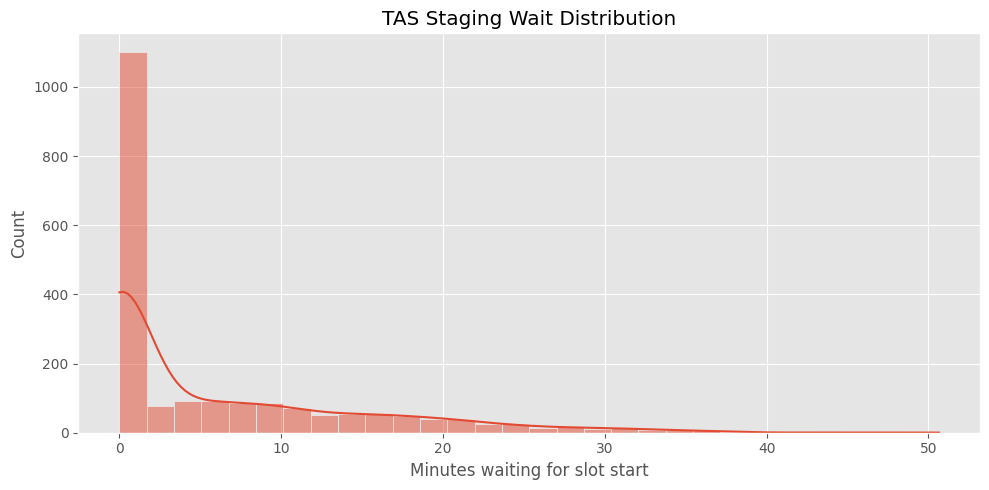

Saved: figures\run_20251229_143846\tas_staging_wait.png


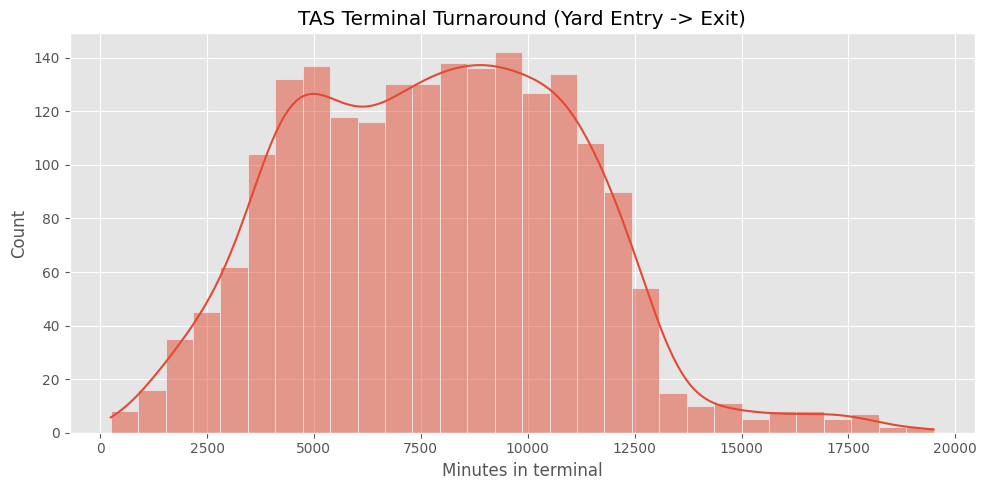

Saved: figures\run_20251229_143846\tas_ttt_terminal.png


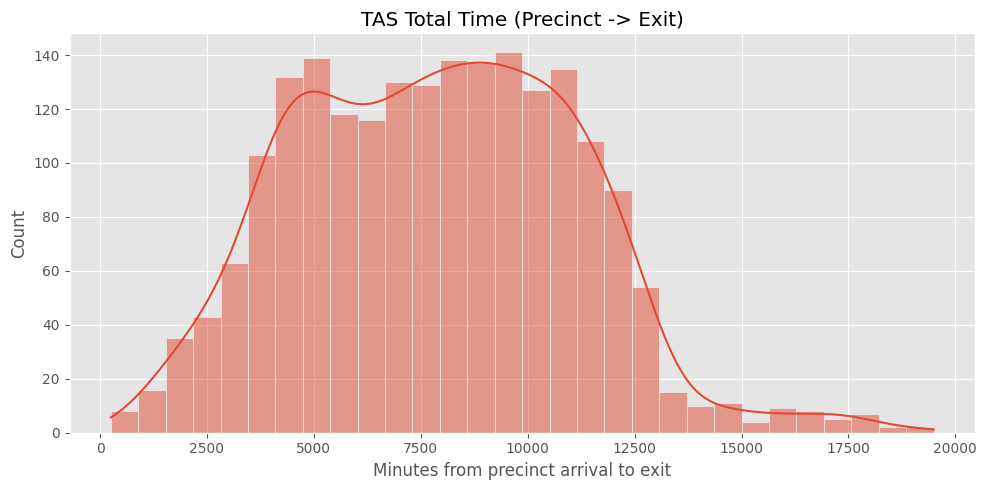

Saved: figures\run_20251229_143846\tas_total_time.png


In [22]:
# -----------------------------------------
# TAS Plots + Summary
# -----------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime as dt

df_trucks_tas = tas_truck_metrics_to_dataframe(TRUCK_METRICS_TAS)

if df_trucks_tas.empty:
    print("No TAS truck metrics to plot yet.")
else:
    if "TTT_terminal" in df_trucks_tas.columns:
        ttt = df_trucks_tas["TTT_terminal"].dropna()
        if not ttt.empty:
            print(
                "TAS - TTT_terminal (min) mean/median/p90: "
                f"{ttt.mean():.1f} / {ttt.median():.1f} / {ttt.quantile(0.9):.1f}"
            )
        else:
            print("TTT_terminal is empty; check TAS metrics.")
    else:
        print("TTT_terminal column missing; check TAS metrics.")

    run_stamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    fig_dir = Path("figures") / f"run_{run_stamp}"
    fig_dir.mkdir(parents=True, exist_ok=True)

    def plot_tas_metric(data, column, title, xlabel, filename):
        if column not in data.columns:
            print(f"Skipping {column}: column not found.")
            return
        plt.figure(figsize=(10, 5))
        sns.histplot(data[column], kde=True, bins=30)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Count")
        out = fig_dir / filename
        plt.tight_layout()
        plt.savefig(out, dpi=150)
        plt.show()
        print(f"Saved: {out}")

    plot_tas_metric(
        df_trucks_tas,
        "staging_wait",
        "TAS Staging Wait Distribution",
        "Minutes waiting for slot start",
        "tas_staging_wait.png",
    )

    plot_tas_metric(
        df_trucks_tas,
        "TTT_terminal",
        "TAS Terminal Turnaround (Yard Entry -> Exit)",
        "Minutes in terminal",
        "tas_ttt_terminal.png",
    )

    plot_tas_metric(
        df_trucks_tas,
        "total_time",
        "TAS Total Time (Precinct -> Exit)",
        "Minutes from precinct arrival to exit",
        "tas_total_time.png",
    )


What changed & why
- Replaced fixed 3/5/7 day dwell with an integrated MVIA-style process (free-time behavior, customs holds, rebooking).
- Added an inspection resource to approximate customs queues instead of pure delay.
- Tuned queue thresholds and loading capacity assumptions to better align with operational scale.
- Added new timestamps and KPIs (pre_pickup_wait, customs_hold_delay, rebook_delay, dwell_terminal).
- Added dwell and pre-pickup plots with a 72-hour reference line for KPI interpretation.
- Added a Truck + TAS (Phase 2) section with NHPP arrivals, slot validation, and staging wait logic.
- Added TAS-specific metrics and plots (staging wait, terminal TTT, total time).
- Added pooled yard equipment constraints for yard-to-scan and yard-to-truck moves with congestion-sensitive move times.
- Added yard equipment stress and availability sensitivity runs to expose bottleneck behavior.
